### Cab-Driver Agent

In [84]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import warnings
warnings. filterwarnings('ignore')

#### Defining Time Matrix

In [85]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [131]:
States_track = collections.defaultdict(dict)

# Initialising states to be tracked
def initialise_tracking_states():
    # selecting any 5 Q-values
    sample_q_values = [((1,11,5),(1,4)),((1,6,4),(1,4))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []



In [132]:
initialise_tracking_states()

In [95]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [136]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        self.epsilon=1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done_boolean = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            q_val= self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([q_val[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        
        for state in States_track.keys():
            qvals = self.model.predict(env.state_encod_arch1(state).reshape(1, self.state_size))
            for action in States_track[state].keys():
                i = action_space.index(list(action))
                States_track[state][action].append(qvals[0][i])
                

    def save(self, name):
        self.model.save(name)

In [137]:
Episodes = 10000

### DQN block

In [138]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0

    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    
    while not terminal_state:
        
        # Write your code here
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_current_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_current_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_current_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_current_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
        
    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))

    agent.save_tracking_states()
    
    # every few episodes:
    if episode % 1000 == 0:
        # save model weights
        agent.save(name="model.h5")

        

Initial State is  [4, 16, 2]
episode 0, reward -260.0, memory_length 127, epsilon 0.999, time 727.0, rides 126
Initial State is  [1, 13, 3]
episode 1, reward -14.0, memory_length 249, epsilon 0.998001, time 725.0, rides 121
Initial State is  [3, 6, 1]
episode 2, reward -80.0, memory_length 379, epsilon 0.997002999, time 725.0, rides 129
Initial State is  [3, 12, 3]
episode 3, reward -225.0, memory_length 492, epsilon 0.996005996001, time 723.0, rides 112
Initial State is  [4, 4, 3]
episode 4, reward -339.0, memory_length 620, epsilon 0.995009990004999, time 730.0, rides 127
Initial State is  [2, 0, 6]
episode 5, reward -249.0, memory_length 744, epsilon 0.994014980014994, time 733.0, rides 123
Initial State is  [1, 20, 6]
episode 6, reward -499.0, memory_length 877, epsilon 0.993020965034979, time 726.0, rides 132
Initial State is  [2, 10, 2]
episode 7, reward -200.0, memory_length 1009, epsilon 0.9920279440699441, time 731.0, rides 131
Initial State is  [1, 3, 4]
episode 8, reward -19

episode 66, reward -212.0, memory_length 2000, epsilon 0.9351638519212846, time 737.0, rides 129
Initial State is  [1, 10, 1]
episode 67, reward -310.0, memory_length 2000, epsilon 0.9342286880693633, time 725.0, rides 141
Initial State is  [2, 4, 4]
episode 68, reward -454.0, memory_length 2000, epsilon 0.933294459381294, time 738.0, rides 129
Initial State is  [4, 17, 3]
episode 69, reward -232.0, memory_length 2000, epsilon 0.9323611649219127, time 732.0, rides 131
Initial State is  [0, 22, 6]
episode 70, reward -109.0, memory_length 2000, epsilon 0.9314288037569908, time 728.0, rides 128
Initial State is  [2, 5, 3]
episode 71, reward -405.0, memory_length 2000, epsilon 0.9304973749532338, time 731.0, rides 123
Initial State is  [4, 11, 3]
episode 72, reward -53.0, memory_length 2000, epsilon 0.9295668775782806, time 732.0, rides 121
Initial State is  [4, 18, 1]
episode 73, reward -184.0, memory_length 2000, epsilon 0.9286373107007023, time 726.0, rides 114
Initial State is  [1, 16,

episode 132, reward -339.0, memory_length 2000, epsilon 0.8754068367770318, time 737.0, rides 147
Initial State is  [3, 6, 1]
episode 133, reward -302.0, memory_length 2000, epsilon 0.8745314299402548, time 727.0, rides 130
Initial State is  [4, 6, 6]
episode 134, reward -93.0, memory_length 2000, epsilon 0.8736568985103146, time 731.0, rides 127
Initial State is  [1, 5, 4]
episode 135, reward -114.0, memory_length 2000, epsilon 0.8727832416118043, time 733.0, rides 128
Initial State is  [0, 12, 5]
episode 136, reward -262.0, memory_length 2000, epsilon 0.8719104583701925, time 731.0, rides 115
Initial State is  [0, 15, 5]
episode 137, reward 35.0, memory_length 2000, epsilon 0.8710385479118223, time 724.0, rides 131
Initial State is  [3, 18, 6]
episode 138, reward -126.0, memory_length 2000, epsilon 0.8701675093639105, time 734.0, rides 118
Initial State is  [4, 17, 0]
episode 139, reward -387.0, memory_length 2000, epsilon 0.8692973418545467, time 725.0, rides 121
Initial State is  [

episode 198, reward -102.0, memory_length 2000, epsilon 0.8194682977764125, time 727.0, rides 150
Initial State is  [3, 22, 3]
episode 199, reward 74.0, memory_length 2000, epsilon 0.818648829478636, time 725.0, rides 132
Initial State is  [1, 6, 2]
episode 200, reward 55.0, memory_length 2000, epsilon 0.8178301806491574, time 735.0, rides 117
Initial State is  [1, 23, 3]
episode 201, reward -280.0, memory_length 2000, epsilon 0.8170123504685082, time 745.0, rides 125
Initial State is  [2, 18, 2]
episode 202, reward 178.0, memory_length 2000, epsilon 0.8161953381180397, time 731.0, rides 131
Initial State is  [4, 0, 1]
episode 203, reward -91.0, memory_length 2000, epsilon 0.8153791427799216, time 731.0, rides 127
Initial State is  [0, 7, 4]
episode 204, reward -164.0, memory_length 2000, epsilon 0.8145637636371417, time 731.0, rides 134
Initial State is  [1, 12, 5]
episode 205, reward 130.0, memory_length 2000, epsilon 0.8137491998735046, time 727.0, rides 118
Initial State is  [1, 19

episode 264, reward -191.0, memory_length 2000, epsilon 0.7671042341100781, time 726.0, rides 119
Initial State is  [2, 8, 3]
episode 265, reward 120.0, memory_length 2000, epsilon 0.766337129875968, time 736.0, rides 126
Initial State is  [4, 20, 0]
episode 266, reward -359.0, memory_length 2000, epsilon 0.7655707927460921, time 722.0, rides 105
Initial State is  [0, 8, 4]
episode 267, reward -28.0, memory_length 2000, epsilon 0.764805221953346, time 734.0, rides 130
Initial State is  [4, 7, 1]
episode 268, reward 12.0, memory_length 2000, epsilon 0.7640404167313927, time 726.0, rides 126
Initial State is  [1, 14, 5]
episode 269, reward -107.0, memory_length 2000, epsilon 0.7632763763146613, time 726.0, rides 128
Initial State is  [1, 20, 3]
episode 270, reward 24.0, memory_length 2000, epsilon 0.7625130999383466, time 724.0, rides 124
Initial State is  [1, 14, 1]
episode 271, reward -337.0, memory_length 2000, epsilon 0.7617505868384082, time 731.0, rides 118
Initial State is  [2, 16

episode 330, reward -197.0, memory_length 2000, epsilon 0.7180862366321393, time 735.0, rides 118
Initial State is  [1, 17, 6]
episode 331, reward 246.0, memory_length 2000, epsilon 0.7173681503955072, time 725.0, rides 129
Initial State is  [1, 3, 0]
episode 332, reward -39.0, memory_length 2000, epsilon 0.7166507822451117, time 735.0, rides 132
Initial State is  [4, 11, 1]
episode 333, reward 19.0, memory_length 2000, epsilon 0.7159341314628666, time 729.0, rides 121
Initial State is  [1, 20, 1]
episode 334, reward 58.0, memory_length 2000, epsilon 0.7152181973314037, time 732.0, rides 128
Initial State is  [4, 8, 5]
episode 335, reward -46.0, memory_length 2000, epsilon 0.7145029791340722, time 736.0, rides 127
Initial State is  [4, 13, 5]
episode 336, reward 314.0, memory_length 2000, epsilon 0.7137884761549381, time 726.0, rides 129
Initial State is  [3, 4, 1]
episode 337, reward -51.0, memory_length 2000, epsilon 0.7130746876787832, time 725.0, rides 122
Initial State is  [4, 9, 

episode 396, reward 69.0, memory_length 2000, epsilon 0.6722004915521225, time 725.0, rides 122
Initial State is  [0, 12, 6]
episode 397, reward -98.0, memory_length 2000, epsilon 0.6715282910605703, time 723.0, rides 133
Initial State is  [3, 14, 5]
episode 398, reward -100.0, memory_length 2000, epsilon 0.6708567627695098, time 728.0, rides 128
Initial State is  [0, 21, 0]
episode 399, reward -116.0, memory_length 2000, epsilon 0.6701859060067403, time 728.0, rides 124
Initial State is  [3, 22, 0]
episode 400, reward -52.0, memory_length 2000, epsilon 0.6695157201007336, time 738.0, rides 122
Initial State is  [0, 3, 0]
episode 401, reward -117.0, memory_length 2000, epsilon 0.6688462043806328, time 730.0, rides 130
Initial State is  [1, 18, 2]
episode 402, reward -78.0, memory_length 2000, epsilon 0.6681773581762521, time 727.0, rides 129
Initial State is  [4, 14, 4]
episode 403, reward 11.0, memory_length 2000, epsilon 0.6675091808180759, time 735.0, rides 130
Initial State is  [3,

episode 462, reward -144.0, memory_length 2000, epsilon 0.6292468477910546, time 731.0, rides 122
Initial State is  [4, 3, 5]
episode 463, reward 68.0, memory_length 2000, epsilon 0.6286176009432635, time 739.0, rides 114
Initial State is  [4, 5, 5]
episode 464, reward -59.0, memory_length 2000, epsilon 0.6279889833423202, time 733.0, rides 119
Initial State is  [1, 16, 1]
episode 465, reward 409.0, memory_length 2000, epsilon 0.6273609943589779, time 723.0, rides 122
Initial State is  [2, 9, 6]
episode 466, reward -72.0, memory_length 2000, epsilon 0.6267336333646188, time 727.0, rides 118
Initial State is  [4, 14, 2]
episode 467, reward -74.0, memory_length 2000, epsilon 0.6261068997312542, time 730.0, rides 128
Initial State is  [3, 15, 2]
episode 468, reward 33.0, memory_length 2000, epsilon 0.6254807928315229, time 730.0, rides 118
Initial State is  [0, 1, 2]
episode 469, reward -206.0, memory_length 2000, epsilon 0.6248553120386914, time 735.0, rides 121
Initial State is  [2, 13,

episode 528, reward 21.0, memory_length 2000, epsilon 0.5890379439335424, time 733.0, rides 130
Initial State is  [0, 20, 6]
episode 529, reward 497.0, memory_length 2000, epsilon 0.5884489059896089, time 726.0, rides 123
Initial State is  [1, 6, 6]
episode 530, reward 303.0, memory_length 2000, epsilon 0.5878604570836192, time 734.0, rides 121
Initial State is  [1, 16, 6]
episode 531, reward -220.0, memory_length 2000, epsilon 0.5872725966265356, time 728.0, rides 109
Initial State is  [2, 3, 2]
episode 532, reward 97.0, memory_length 2000, epsilon 0.5866853240299091, time 736.0, rides 118
Initial State is  [1, 18, 4]
episode 533, reward -228.0, memory_length 2000, epsilon 0.5860986387058792, time 725.0, rides 121
Initial State is  [0, 13, 2]
episode 534, reward 409.0, memory_length 2000, epsilon 0.5855125400671733, time 730.0, rides 130
Initial State is  [2, 10, 1]
episode 535, reward 152.0, memory_length 2000, epsilon 0.5849270275271061, time 725.0, rides 122
Initial State is  [0, 1

episode 594, reward 171.0, memory_length 2000, epsilon 0.5513983909676525, time 737.0, rides 124
Initial State is  [4, 20, 6]
episode 595, reward -21.0, memory_length 2000, epsilon 0.5508469925766849, time 730.0, rides 131
Initial State is  [3, 19, 4]
episode 596, reward 265.0, memory_length 2000, epsilon 0.5502961455841082, time 724.0, rides 122
Initial State is  [1, 1, 5]
episode 597, reward 15.0, memory_length 2000, epsilon 0.5497458494385241, time 729.0, rides 125
Initial State is  [3, 8, 4]
episode 598, reward 278.0, memory_length 2000, epsilon 0.5491961035890855, time 737.0, rides 121
Initial State is  [3, 0, 3]
episode 599, reward 35.0, memory_length 2000, epsilon 0.5486469074854965, time 729.0, rides 135
Initial State is  [4, 20, 3]
episode 600, reward 382.0, memory_length 2000, epsilon 0.548098260578011, time 732.0, rides 131
Initial State is  [0, 20, 3]
episode 601, reward 58.0, memory_length 2000, epsilon 0.547550162317433, time 736.0, rides 123
Initial State is  [3, 1, 0]
e

episode 660, reward 27.0, memory_length 2000, epsilon 0.5161640072477562, time 734.0, rides 131
Initial State is  [2, 17, 3]
episode 661, reward -115.0, memory_length 2000, epsilon 0.5156478432405085, time 732.0, rides 125
Initial State is  [4, 5, 1]
episode 662, reward 256.0, memory_length 2000, epsilon 0.515132195397268, time 727.0, rides 124
Initial State is  [3, 9, 1]
episode 663, reward 220.0, memory_length 2000, epsilon 0.5146170632018707, time 723.0, rides 118
Initial State is  [1, 13, 1]
episode 664, reward -25.0, memory_length 2000, epsilon 0.5141024461386688, time 735.0, rides 134
Initial State is  [2, 0, 6]
episode 665, reward 394.0, memory_length 2000, epsilon 0.5135883436925301, time 729.0, rides 127
Initial State is  [2, 9, 3]
episode 666, reward -161.0, memory_length 2000, epsilon 0.5130747553488376, time 728.0, rides 114
Initial State is  [1, 6, 3]
episode 667, reward 526.0, memory_length 2000, epsilon 0.5125616805934888, time 735.0, rides 131
Initial State is  [0, 12, 

episode 726, reward 189.0, memory_length 2000, epsilon 0.4831811023432807, time 728.0, rides 125
Initial State is  [1, 4, 6]
episode 727, reward 181.0, memory_length 2000, epsilon 0.4826979212409374, time 727.0, rides 128
Initial State is  [1, 17, 4]
episode 728, reward 157.0, memory_length 2000, epsilon 0.48221522331969646, time 725.0, rides 115
Initial State is  [0, 22, 0]
episode 729, reward 109.0, memory_length 2000, epsilon 0.48173300809637676, time 725.0, rides 125
Initial State is  [2, 22, 5]
episode 730, reward 515.0, memory_length 2000, epsilon 0.48125127508828036, time 728.0, rides 120
Initial State is  [1, 3, 6]
episode 731, reward 204.0, memory_length 2000, epsilon 0.48077002381319206, time 737.0, rides 126
Initial State is  [4, 18, 0]
episode 732, reward 245.0, memory_length 2000, epsilon 0.48028925378937887, time 731.0, rides 124
Initial State is  [3, 4, 0]
episode 733, reward 461.0, memory_length 2000, epsilon 0.47980896453558947, time 729.0, rides 134
Initial State is  

episode 792, reward 303.0, memory_length 2000, epsilon 0.4523058066495642, time 727.0, rides 136
Initial State is  [3, 21, 1]
episode 793, reward 232.0, memory_length 2000, epsilon 0.45185350084291465, time 732.0, rides 141
Initial State is  [2, 10, 5]
episode 794, reward 372.0, memory_length 2000, epsilon 0.4514016473420717, time 732.0, rides 105
Initial State is  [2, 14, 5]
episode 795, reward 328.0, memory_length 2000, epsilon 0.45095024569472963, time 730.0, rides 121
Initial State is  [2, 17, 0]
episode 796, reward 303.0, memory_length 2000, epsilon 0.4504992954490349, time 727.0, rides 119
Initial State is  [3, 12, 2]
episode 797, reward 259.0, memory_length 2000, epsilon 0.45004879615358584, time 723.0, rides 116
Initial State is  [0, 5, 4]
episode 798, reward 189.0, memory_length 2000, epsilon 0.44959874735743227, time 732.0, rides 129
Initial State is  [3, 12, 0]
episode 799, reward 380.0, memory_length 2000, epsilon 0.4491491486100748, time 729.0, rides 125
Initial State is  

episode 858, reward 281.0, memory_length 2000, epsilon 0.4234034438366067, time 733.0, rides 121
Initial State is  [1, 18, 4]
episode 859, reward 282.0, memory_length 2000, epsilon 0.4229800403927701, time 721.0, rides 129
Initial State is  [1, 10, 1]
episode 860, reward 275.0, memory_length 2000, epsilon 0.42255706035237733, time 730.0, rides 124
Initial State is  [1, 14, 5]
episode 861, reward 220.0, memory_length 2000, epsilon 0.42213450329202495, time 731.0, rides 124
Initial State is  [1, 16, 3]
episode 862, reward 181.0, memory_length 2000, epsilon 0.4217123687887329, time 737.0, rides 133
Initial State is  [0, 18, 1]
episode 863, reward 406.0, memory_length 2000, epsilon 0.4212906564199442, time 733.0, rides 118
Initial State is  [4, 16, 5]
episode 864, reward 609.0, memory_length 2000, epsilon 0.42086936576352424, time 734.0, rides 134
Initial State is  [2, 8, 0]
episode 865, reward 430.0, memory_length 2000, epsilon 0.4204484963977607, time 727.0, rides 128
Initial State is  [

episode 924, reward 650.0, memory_length 2000, epsilon 0.3963479433983767, time 734.0, rides 136
Initial State is  [0, 16, 2]
episode 925, reward 408.0, memory_length 2000, epsilon 0.3959515954549783, time 724.0, rides 121
Initial State is  [1, 12, 6]
episode 926, reward 429.0, memory_length 2000, epsilon 0.39555564385952335, time 728.0, rides 131
Initial State is  [2, 11, 6]
episode 927, reward 276.0, memory_length 2000, epsilon 0.39516008821566384, time 731.0, rides 137
Initial State is  [2, 9, 0]
episode 928, reward 334.0, memory_length 2000, epsilon 0.3947649281274482, time 728.0, rides 118
Initial State is  [4, 23, 0]
episode 929, reward 397.0, memory_length 2000, epsilon 0.3943701631993207, time 725.0, rides 120
Initial State is  [3, 3, 0]
episode 930, reward 261.0, memory_length 2000, epsilon 0.3939757930361214, time 732.0, rides 132
Initial State is  [1, 6, 5]
episode 931, reward 377.0, memory_length 2000, epsilon 0.3935818172430853, time 731.0, rides 126
Initial State is  [2, 

episode 990, reward 115.0, memory_length 2000, epsilon 0.37102129074024554, time 731.0, rides 127
Initial State is  [1, 6, 0]
episode 991, reward 312.0, memory_length 2000, epsilon 0.3706502694495053, time 730.0, rides 139
Initial State is  [1, 23, 4]
episode 992, reward 534.0, memory_length 2000, epsilon 0.3702796191800558, time 726.0, rides 129
Initial State is  [0, 13, 0]
episode 993, reward 325.0, memory_length 2000, epsilon 0.36990933956087574, time 734.0, rides 134
Initial State is  [2, 21, 6]
episode 994, reward 374.0, memory_length 2000, epsilon 0.36953943022131486, time 724.0, rides 126
Initial State is  [1, 16, 1]
episode 995, reward 423.0, memory_length 2000, epsilon 0.3691698907910935, time 741.0, rides 141
Initial State is  [4, 1, 0]
episode 996, reward 528.0, memory_length 2000, epsilon 0.3688007209003024, time 729.0, rides 120
Initial State is  [1, 22, 4]
episode 997, reward 468.0, memory_length 2000, epsilon 0.36843192017940213, time 728.0, rides 136
Initial State is  [

episode 1055, reward 303.0, memory_length 2000, epsilon 0.34766067307894, time 726.0, rides 121
Initial State is  [1, 9, 5]
episode 1056, reward 452.0, memory_length 2000, epsilon 0.34731301240586104, time 735.0, rides 130
Initial State is  [1, 2, 1]
episode 1057, reward 259.0, memory_length 2000, epsilon 0.3469656993934552, time 729.0, rides 112
Initial State is  [4, 14, 0]
episode 1058, reward 475.0, memory_length 2000, epsilon 0.3466187336940617, time 722.0, rides 130
Initial State is  [2, 20, 6]
episode 1059, reward 498.0, memory_length 2000, epsilon 0.34627211496036764, time 725.0, rides 130
Initial State is  [1, 6, 6]
episode 1060, reward 214.0, memory_length 2000, epsilon 0.3459258428454073, time 729.0, rides 126
Initial State is  [3, 5, 0]
episode 1061, reward 534.0, memory_length 2000, epsilon 0.34557991700256185, time 741.0, rides 126
Initial State is  [2, 19, 2]
episode 1062, reward 4.0, memory_length 2000, epsilon 0.3452343370855593, time 731.0, rides 122
Initial State is  

episode 1120, reward 522.0, memory_length 2000, epsilon 0.325770910247633, time 732.0, rides 127
Initial State is  [0, 6, 3]
episode 1121, reward 300.0, memory_length 2000, epsilon 0.32544513933738534, time 728.0, rides 126
Initial State is  [1, 14, 0]
episode 1122, reward 313.0, memory_length 2000, epsilon 0.3251196941980479, time 725.0, rides 131
Initial State is  [1, 11, 5]
episode 1123, reward 268.0, memory_length 2000, epsilon 0.32479457450384985, time 732.0, rides 117
Initial State is  [4, 19, 2]
episode 1124, reward 583.0, memory_length 2000, epsilon 0.324469779929346, time 734.0, rides 115
Initial State is  [3, 0, 2]
episode 1125, reward 422.0, memory_length 2000, epsilon 0.32414531014941667, time 731.0, rides 117
Initial State is  [2, 4, 3]
episode 1126, reward 470.0, memory_length 2000, epsilon 0.32382116483926726, time 732.0, rides 124
Initial State is  [0, 10, 5]
episode 1127, reward 391.0, memory_length 2000, epsilon 0.323497343674428, time 731.0, rides 138
Initial State i

episode 1185, reward 306.0, memory_length 2000, epsilon 0.30525939279728115, time 729.0, rides 130
Initial State is  [2, 3, 4]
episode 1186, reward 407.0, memory_length 2000, epsilon 0.30495413340448385, time 725.0, rides 131
Initial State is  [0, 18, 2]
episode 1187, reward 307.0, memory_length 2000, epsilon 0.3046491792710794, time 727.0, rides 128
Initial State is  [2, 22, 4]
episode 1188, reward 676.0, memory_length 2000, epsilon 0.3043445300918083, time 732.0, rides 138
Initial State is  [4, 4, 4]
episode 1189, reward 321.0, memory_length 2000, epsilon 0.30404018556171647, time 723.0, rides 130
Initial State is  [3, 7, 5]
episode 1190, reward 236.0, memory_length 2000, epsilon 0.30373614537615473, time 726.0, rides 116
Initial State is  [3, 16, 6]
episode 1191, reward 554.0, memory_length 2000, epsilon 0.3034324092307786, time 730.0, rides 131
Initial State is  [1, 15, 0]
episode 1192, reward 600.0, memory_length 2000, epsilon 0.3031289768215478, time 735.0, rides 140
Initial Stat

episode 1250, reward 143.0, memory_length 2000, epsilon 0.28603934224861294, time 722.0, rides 126
Initial State is  [2, 9, 2]
episode 1251, reward 252.0, memory_length 2000, epsilon 0.2857533029063643, time 727.0, rides 144
Initial State is  [3, 1, 6]
episode 1252, reward 392.0, memory_length 2000, epsilon 0.28546754960345794, time 733.0, rides 118
Initial State is  [2, 16, 5]
episode 1253, reward 535.0, memory_length 2000, epsilon 0.2851820820538545, time 724.0, rides 120
Initial State is  [1, 2, 4]
episode 1254, reward 566.0, memory_length 2000, epsilon 0.2848968999718006, time 722.0, rides 124
Initial State is  [2, 23, 4]
episode 1255, reward 374.0, memory_length 2000, epsilon 0.2846120030718288, time 725.0, rides 120
Initial State is  [2, 10, 2]
episode 1256, reward 280.0, memory_length 2000, epsilon 0.284327391068757, time 723.0, rides 121
Initial State is  [2, 10, 6]
episode 1257, reward 297.0, memory_length 2000, epsilon 0.2840430636776882, time 730.0, rides 117
Initial State i

episode 1315, reward 589.0, memory_length 2000, epsilon 0.268029443956713, time 729.0, rides 123
Initial State is  [3, 18, 1]
episode 1316, reward 422.0, memory_length 2000, epsilon 0.2677614145127563, time 727.0, rides 131
Initial State is  [3, 16, 3]
episode 1317, reward 451.0, memory_length 2000, epsilon 0.2674936530982436, time 723.0, rides 109
Initial State is  [1, 11, 1]
episode 1318, reward 352.0, memory_length 2000, epsilon 0.26722615944514533, time 730.0, rides 135
Initial State is  [0, 8, 0]
episode 1319, reward 536.0, memory_length 2000, epsilon 0.2669589332857002, time 728.0, rides 128
Initial State is  [3, 13, 4]
episode 1320, reward 310.0, memory_length 2000, epsilon 0.2666919743524145, time 733.0, rides 128
Initial State is  [4, 4, 5]
episode 1321, reward 495.0, memory_length 2000, epsilon 0.26642528237806207, time 732.0, rides 133
Initial State is  [1, 19, 1]
episode 1322, reward 487.0, memory_length 2000, epsilon 0.266158857095684, time 730.0, rides 121
Initial State i

episode 1380, reward 655.0, memory_length 2000, epsilon 0.25115350309155987, time 724.0, rides 116
Initial State is  [0, 9, 5]
episode 1381, reward 466.0, memory_length 2000, epsilon 0.2509023495884683, time 729.0, rides 132
Initial State is  [0, 4, 1]
episode 1382, reward 429.0, memory_length 2000, epsilon 0.25065144723887983, time 731.0, rides 123
Initial State is  [2, 21, 5]
episode 1383, reward 692.0, memory_length 2000, epsilon 0.25040079579164093, time 730.0, rides 130
Initial State is  [3, 15, 5]
episode 1384, reward 567.0, memory_length 2000, epsilon 0.2501503949958493, time 728.0, rides 137
Initial State is  [1, 9, 5]
episode 1385, reward 353.0, memory_length 2000, epsilon 0.24990024460085344, time 724.0, rides 124
Initial State is  [0, 5, 4]
episode 1386, reward 373.0, memory_length 2000, epsilon 0.24965034435625258, time 727.0, rides 130
Initial State is  [0, 16, 2]
episode 1387, reward 588.0, memory_length 2000, epsilon 0.24940069401189632, time 723.0, rides 133
Initial Sta

episode 1445, reward 779.0, memory_length 2000, epsilon 0.2353401222790632, time 734.0, rides 131
Initial State is  [1, 11, 2]
episode 1446, reward 782.0, memory_length 2000, epsilon 0.23510478215678413, time 730.0, rides 125
Initial State is  [0, 6, 4]
episode 1447, reward 771.0, memory_length 2000, epsilon 0.23486967737462733, time 728.0, rides 135
Initial State is  [0, 8, 5]
episode 1448, reward 568.0, memory_length 2000, epsilon 0.2346348076972527, time 730.0, rides 133
Initial State is  [2, 3, 4]
episode 1449, reward 626.0, memory_length 2000, epsilon 0.23440017288955545, time 730.0, rides 141
Initial State is  [2, 2, 0]
episode 1450, reward 553.0, memory_length 2000, epsilon 0.2341657727166659, time 729.0, rides 120
Initial State is  [0, 11, 5]
episode 1451, reward 683.0, memory_length 2000, epsilon 0.2339316069439492, time 732.0, rides 123
Initial State is  [2, 18, 3]
episode 1452, reward 695.0, memory_length 2000, epsilon 0.23369767533700525, time 729.0, rides 117
Initial State

episode 1510, reward 612.0, memory_length 2000, epsilon 0.22052239953879277, time 723.0, rides 125
Initial State is  [4, 12, 2]
episode 1511, reward 625.0, memory_length 2000, epsilon 0.22030187713925398, time 725.0, rides 122
Initial State is  [3, 3, 2]
episode 1512, reward 581.0, memory_length 2000, epsilon 0.22008157526211472, time 727.0, rides 117
Initial State is  [0, 6, 1]
episode 1513, reward 355.0, memory_length 2000, epsilon 0.2198614936868526, time 724.0, rides 119
Initial State is  [4, 20, 1]
episode 1514, reward 588.0, memory_length 2000, epsilon 0.21964163219316574, time 726.0, rides 122
Initial State is  [1, 16, 4]
episode 1515, reward 509.0, memory_length 2000, epsilon 0.21942199056097256, time 730.0, rides 117
Initial State is  [0, 16, 5]
episode 1516, reward 272.0, memory_length 2000, epsilon 0.2192025685704116, time 731.0, rides 117
Initial State is  [3, 3, 1]
episode 1517, reward 535.0, memory_length 2000, epsilon 0.21898336600184118, time 725.0, rides 133
Initial St

episode 1575, reward 997.0, memory_length 2000, epsilon 0.20663764524045758, time 726.0, rides 132
Initial State is  [2, 5, 1]
episode 1576, reward 532.0, memory_length 2000, epsilon 0.20643100759521713, time 728.0, rides 120
Initial State is  [0, 10, 4]
episode 1577, reward 306.0, memory_length 2000, epsilon 0.20622457658762192, time 725.0, rides 136
Initial State is  [0, 8, 4]
episode 1578, reward 296.0, memory_length 2000, epsilon 0.2060183520110343, time 729.0, rides 130
Initial State is  [0, 16, 6]
episode 1579, reward 363.0, memory_length 2000, epsilon 0.20581233365902327, time 730.0, rides 120
Initial State is  [2, 9, 1]
episode 1580, reward 869.0, memory_length 2000, epsilon 0.20560652132536425, time 727.0, rides 133
Initial State is  [2, 14, 0]
episode 1581, reward 504.0, memory_length 2000, epsilon 0.20540091480403888, time 724.0, rides 130
Initial State is  [0, 5, 2]
episode 1582, reward 682.0, memory_length 2000, epsilon 0.20519551388923485, time 730.0, rides 120
Initial St

episode 1640, reward 623.0, memory_length 2000, epsilon 0.19362711688165665, time 728.0, rides 141
Initial State is  [1, 0, 3]
episode 1641, reward 366.0, memory_length 2000, epsilon 0.193433489764775, time 730.0, rides 131
Initial State is  [2, 12, 0]
episode 1642, reward 631.0, memory_length 2000, epsilon 0.19324005627501023, time 727.0, rides 125
Initial State is  [0, 8, 0]
episode 1643, reward 691.0, memory_length 2000, epsilon 0.1930468162187352, time 725.0, rides 120
Initial State is  [1, 10, 5]
episode 1644, reward 1016.0, memory_length 2000, epsilon 0.19285376940251647, time 732.0, rides 126
Initial State is  [3, 9, 3]
episode 1645, reward 345.0, memory_length 2000, epsilon 0.19266091563311397, time 728.0, rides 115
Initial State is  [1, 11, 0]
episode 1646, reward 476.0, memory_length 2000, epsilon 0.19246825471748086, time 721.0, rides 135
Initial State is  [2, 8, 2]
episode 1647, reward 530.0, memory_length 2000, epsilon 0.1922757864627634, time 734.0, rides 137
Initial Stat

episode 1705, reward 775.0, memory_length 2000, epsilon 0.1814357705648218, time 720.0, rides 133
Initial State is  [0, 13, 5]
episode 1706, reward 771.0, memory_length 2000, epsilon 0.18125433479425698, time 723.0, rides 120
Initial State is  [1, 15, 2]
episode 1707, reward 356.0, memory_length 2000, epsilon 0.18107308045946272, time 725.0, rides 120
Initial State is  [0, 1, 4]
episode 1708, reward 769.0, memory_length 2000, epsilon 0.18089200737900324, time 723.0, rides 127
Initial State is  [1, 10, 1]
episode 1709, reward 667.0, memory_length 2000, epsilon 0.18071111537162424, time 728.0, rides 118
Initial State is  [4, 12, 5]
episode 1710, reward 749.0, memory_length 2000, epsilon 0.1805304042562526, time 731.0, rides 129
Initial State is  [2, 20, 0]
episode 1711, reward 728.0, memory_length 2000, epsilon 0.18034987385199636, time 734.0, rides 124
Initial State is  [2, 7, 0]
episode 1712, reward 601.0, memory_length 2000, epsilon 0.18016952397814437, time 729.0, rides 130
Initial S

episode 1770, reward 721.0, memory_length 2000, epsilon 0.17001202812192093, time 728.0, rides 127
Initial State is  [2, 6, 0]
episode 1771, reward 463.0, memory_length 2000, epsilon 0.169842016093799, time 727.0, rides 123
Initial State is  [4, 3, 3]
episode 1772, reward 477.0, memory_length 2000, epsilon 0.1696721740777052, time 725.0, rides 118
Initial State is  [0, 18, 1]
episode 1773, reward 424.0, memory_length 2000, epsilon 0.1695025019036275, time 721.0, rides 129
Initial State is  [4, 19, 2]
episode 1774, reward 572.0, memory_length 2000, epsilon 0.1693329994017239, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 1775, reward 536.0, memory_length 2000, epsilon 0.16916366640232217, time 731.0, rides 114
Initial State is  [2, 3, 1]
episode 1776, reward 494.0, memory_length 2000, epsilon 0.16899450273591984, time 727.0, rides 117
Initial State is  [2, 5, 1]
episode 1777, reward 668.0, memory_length 2000, epsilon 0.16882550823318393, time 731.0, rides 127
Initial State i

episode 1835, reward 893.0, memory_length 2000, epsilon 0.15930755890168982, time 726.0, rides 135
Initial State is  [1, 16, 5]
episode 1836, reward 395.0, memory_length 2000, epsilon 0.15914825134278812, time 726.0, rides 120
Initial State is  [1, 23, 3]
episode 1837, reward 599.0, memory_length 2000, epsilon 0.15898910309144534, time 735.0, rides 125
Initial State is  [0, 13, 1]
episode 1838, reward 682.0, memory_length 2000, epsilon 0.1588301139883539, time 729.0, rides 126
Initial State is  [3, 13, 1]
episode 1839, reward 489.0, memory_length 2000, epsilon 0.15867128387436555, time 726.0, rides 135
Initial State is  [4, 9, 2]
episode 1840, reward 825.0, memory_length 2000, epsilon 0.15851261259049118, time 722.0, rides 122
Initial State is  [2, 3, 4]
episode 1841, reward 491.0, memory_length 2000, epsilon 0.1583540999779007, time 733.0, rides 136
Initial State is  [0, 8, 2]
episode 1842, reward 617.0, memory_length 2000, epsilon 0.1581957458779228, time 728.0, rides 132
Initial Sta

episode 1900, reward 774.0, memory_length 2000, epsilon 0.14927707529619813, time 730.0, rides 127
Initial State is  [2, 21, 3]
episode 1901, reward 530.0, memory_length 2000, epsilon 0.14912779822090194, time 734.0, rides 126
Initial State is  [4, 3, 1]
episode 1902, reward 796.0, memory_length 2000, epsilon 0.14897867042268104, time 722.0, rides 138
Initial State is  [0, 20, 0]
episode 1903, reward 568.0, memory_length 2000, epsilon 0.14882969175225835, time 721.0, rides 108
Initial State is  [2, 6, 4]
episode 1904, reward 687.0, memory_length 2000, epsilon 0.1486808620605061, time 728.0, rides 133
Initial State is  [0, 11, 1]
episode 1905, reward 738.0, memory_length 2000, epsilon 0.14853218119844558, time 733.0, rides 121
Initial State is  [1, 0, 0]
episode 1906, reward 398.0, memory_length 2000, epsilon 0.14838364901724713, time 730.0, rides 120
Initial State is  [2, 3, 1]
episode 1907, reward 651.0, memory_length 2000, epsilon 0.14823526536822987, time 730.0, rides 132
Initial St

episode 1965, reward 905.0, memory_length 2000, epsilon 0.1398781411416785, time 733.0, rides 129
Initial State is  [3, 22, 3]
episode 1966, reward 588.0, memory_length 2000, epsilon 0.13973826300053682, time 732.0, rides 123
Initial State is  [2, 2, 4]
episode 1967, reward 480.0, memory_length 2000, epsilon 0.13959852473753628, time 725.0, rides 116
Initial State is  [0, 2, 3]
episode 1968, reward 658.0, memory_length 2000, epsilon 0.13945892621279873, time 726.0, rides 117
Initial State is  [2, 10, 4]
episode 1969, reward 676.0, memory_length 2000, epsilon 0.13931946728658592, time 731.0, rides 127
Initial State is  [1, 16, 6]
episode 1970, reward 693.0, memory_length 2000, epsilon 0.13918014781929933, time 730.0, rides 124
Initial State is  [2, 12, 5]
episode 1971, reward 729.0, memory_length 2000, epsilon 0.13904096767148003, time 733.0, rides 123
Initial State is  [0, 17, 4]
episode 1972, reward 469.0, memory_length 2000, epsilon 0.13890192670380855, time 726.0, rides 120
Initial 

episode 2030, reward 770.0, memory_length 2000, epsilon 0.13107099218301493, time 732.0, rides 140
Initial State is  [2, 21, 6]
episode 2031, reward 625.0, memory_length 2000, epsilon 0.13093992119083192, time 723.0, rides 112
Initial State is  [3, 21, 1]
episode 2032, reward 831.0, memory_length 2000, epsilon 0.13080898126964108, time 729.0, rides 124
Initial State is  [1, 2, 4]
episode 2033, reward 608.0, memory_length 2000, epsilon 0.13067817228837145, time 727.0, rides 121
Initial State is  [2, 4, 1]
episode 2034, reward 447.0, memory_length 2000, epsilon 0.13054749411608307, time 731.0, rides 119
Initial State is  [4, 12, 1]
episode 2035, reward 562.0, memory_length 2000, epsilon 0.13041694662196698, time 736.0, rides 127
Initial State is  [0, 15, 2]
episode 2036, reward 906.0, memory_length 2000, epsilon 0.13028652967534501, time 734.0, rides 125
Initial State is  [0, 23, 1]
episode 2037, reward 963.0, memory_length 2000, epsilon 0.13015624314566968, time 733.0, rides 146
Initial

episode 2095, reward 636.0, memory_length 2000, epsilon 0.12281836784232969, time 731.0, rides 127
Initial State is  [4, 3, 4]
episode 2096, reward 664.0, memory_length 2000, epsilon 0.12269554947448735, time 727.0, rides 118
Initial State is  [4, 1, 0]
episode 2097, reward 392.0, memory_length 2000, epsilon 0.12257285392501287, time 725.0, rides 118
Initial State is  [3, 19, 1]
episode 2098, reward 1014.0, memory_length 2000, epsilon 0.12245028107108785, time 722.0, rides 120
Initial State is  [2, 20, 5]
episode 2099, reward 620.0, memory_length 2000, epsilon 0.12232783079001676, time 728.0, rides 127
Initial State is  [2, 10, 3]
episode 2100, reward 549.0, memory_length 2000, epsilon 0.12220550295922675, time 732.0, rides 129
Initial State is  [0, 6, 3]
episode 2101, reward 893.0, memory_length 2000, epsilon 0.12208329745626752, time 728.0, rides 122
Initial State is  [4, 0, 5]
episode 2102, reward 1040.0, memory_length 2000, epsilon 0.12196121415881125, time 721.0, rides 122
Initial

episode 2160, reward 955.0, memory_length 2000, epsilon 0.11508535357992454, time 730.0, rides 121
Initial State is  [1, 9, 4]
episode 2161, reward 502.0, memory_length 2000, epsilon 0.11497026822634461, time 728.0, rides 118
Initial State is  [2, 17, 4]
episode 2162, reward 709.0, memory_length 2000, epsilon 0.11485529795811826, time 733.0, rides 119
Initial State is  [2, 20, 6]
episode 2163, reward 790.0, memory_length 2000, epsilon 0.11474044266016015, time 728.0, rides 131
Initial State is  [1, 11, 3]
episode 2164, reward 881.0, memory_length 2000, epsilon 0.11462570221749999, time 736.0, rides 138
Initial State is  [1, 12, 1]
episode 2165, reward 886.0, memory_length 2000, epsilon 0.11451107651528249, time 743.0, rides 115
Initial State is  [3, 1, 3]
episode 2166, reward 668.0, memory_length 2000, epsilon 0.11439656543876721, time 729.0, rides 129
Initial State is  [1, 23, 1]
episode 2167, reward 1065.0, memory_length 2000, epsilon 0.11428216887332844, time 735.0, rides 128
Initia

episode 2225, reward 763.0, memory_length 2000, epsilon 0.10783923318065335, time 733.0, rides 120
Initial State is  [4, 6, 4]
episode 2226, reward 525.0, memory_length 2000, epsilon 0.10773139394747269, time 726.0, rides 136
Initial State is  [3, 18, 4]
episode 2227, reward 725.0, memory_length 2000, epsilon 0.10762366255352522, time 733.0, rides 122
Initial State is  [4, 20, 4]
episode 2228, reward 832.0, memory_length 2000, epsilon 0.1075160388909717, time 728.0, rides 124
Initial State is  [4, 17, 3]
episode 2229, reward 535.0, memory_length 2000, epsilon 0.10740852285208072, time 736.0, rides 118
Initial State is  [0, 15, 6]
episode 2230, reward 487.0, memory_length 2000, epsilon 0.10730111432922863, time 728.0, rides 124
Initial State is  [3, 3, 5]
episode 2231, reward 604.0, memory_length 2000, epsilon 0.1071938132148994, time 732.0, rides 121
Initial State is  [2, 3, 5]
episode 2232, reward 689.0, memory_length 2000, epsilon 0.1070866194016845, time 728.0, rides 129
Initial Sta

episode 2290, reward 680.0, memory_length 2000, epsilon 0.10104935034078859, time 725.0, rides 119
Initial State is  [2, 3, 3]
episode 2291, reward 544.0, memory_length 2000, epsilon 0.1009483009904478, time 726.0, rides 119
Initial State is  [2, 8, 3]
episode 2292, reward 521.0, memory_length 2000, epsilon 0.10084735268945735, time 735.0, rides 128
Initial State is  [4, 16, 2]
episode 2293, reward 1030.0, memory_length 2000, epsilon 0.10074650533676789, time 729.0, rides 130
Initial State is  [3, 13, 1]
episode 2294, reward 827.0, memory_length 2000, epsilon 0.10064575883143112, time 728.0, rides 132
Initial State is  [3, 11, 6]
episode 2295, reward 493.0, memory_length 2000, epsilon 0.1005451130725997, time 734.0, rides 132
Initial State is  [0, 3, 4]
episode 2296, reward 770.0, memory_length 2000, epsilon 0.1004445679595271, time 727.0, rides 136
Initial State is  [2, 15, 0]
episode 2297, reward 724.0, memory_length 2000, epsilon 0.10034412339156756, time 723.0, rides 124
Initial St

episode 2355, reward 837.0, memory_length 2000, epsilon 0.09468697896979585, time 723.0, rides 147
Initial State is  [2, 15, 5]
episode 2356, reward 754.0, memory_length 2000, epsilon 0.09459229199082606, time 726.0, rides 145
Initial State is  [3, 16, 0]
episode 2357, reward 853.0, memory_length 2000, epsilon 0.09449769969883523, time 727.0, rides 122
Initial State is  [1, 13, 5]
episode 2358, reward 617.0, memory_length 2000, epsilon 0.09440320199913639, time 736.0, rides 112
Initial State is  [3, 8, 4]
episode 2359, reward 808.0, memory_length 2000, epsilon 0.09430879879713726, time 732.0, rides 120
Initial State is  [2, 12, 1]
episode 2360, reward 822.0, memory_length 2000, epsilon 0.09421448999834012, time 730.0, rides 124
Initial State is  [3, 1, 1]
episode 2361, reward 679.0, memory_length 2000, epsilon 0.09412027550834177, time 733.0, rides 129
Initial State is  [2, 15, 4]
episode 2362, reward 531.0, memory_length 2000, epsilon 0.09402615523283343, time 728.0, rides 131
Initial

episode 2420, reward 717.0, memory_length 2000, epsilon 0.0887252016582989, time 731.0, rides 130
Initial State is  [4, 12, 6]
episode 2421, reward 946.0, memory_length 2000, epsilon 0.0886364764566406, time 724.0, rides 136
Initial State is  [0, 8, 2]
episode 2422, reward 638.0, memory_length 2000, epsilon 0.08854783998018396, time 727.0, rides 132
Initial State is  [0, 2, 1]
episode 2423, reward 708.0, memory_length 2000, epsilon 0.08845929214020377, time 725.0, rides 131
Initial State is  [0, 0, 3]
episode 2424, reward 855.0, memory_length 2000, epsilon 0.08837083284806357, time 734.0, rides 137
Initial State is  [0, 3, 6]
episode 2425, reward 708.0, memory_length 2000, epsilon 0.08828246201521552, time 730.0, rides 141
Initial State is  [1, 19, 5]
episode 2426, reward 889.0, memory_length 2000, epsilon 0.0881941795532003, time 722.0, rides 125
Initial State is  [4, 7, 6]
episode 2427, reward 1192.0, memory_length 2000, epsilon 0.0881059853736471, time 733.0, rides 138
Initial State

episode 2485, reward 503.0, memory_length 2000, epsilon 0.08313879579806785, time 731.0, rides 116
Initial State is  [2, 7, 1]
episode 2486, reward 703.0, memory_length 2000, epsilon 0.08305565700226979, time 725.0, rides 128
Initial State is  [3, 11, 2]
episode 2487, reward 588.0, memory_length 2000, epsilon 0.08297260134526752, time 729.0, rides 134
Initial State is  [1, 16, 2]
episode 2488, reward 932.0, memory_length 2000, epsilon 0.08288962874392225, time 729.0, rides 122
Initial State is  [1, 1, 2]
episode 2489, reward 887.0, memory_length 2000, epsilon 0.08280673911517833, time 720.0, rides 127
Initial State is  [0, 17, 2]
episode 2490, reward 334.0, memory_length 2000, epsilon 0.08272393237606315, time 728.0, rides 122
Initial State is  [0, 5, 3]
episode 2491, reward 803.0, memory_length 2000, epsilon 0.0826412084436871, time 734.0, rides 130
Initial State is  [2, 19, 1]
episode 2492, reward 861.0, memory_length 2000, epsilon 0.08255856723524341, time 729.0, rides 130
Initial S

episode 2550, reward 746.0, memory_length 2000, epsilon 0.07790412687223583, time 728.0, rides 134
Initial State is  [0, 9, 6]
episode 2551, reward 809.0, memory_length 2000, epsilon 0.07782622274536359, time 728.0, rides 136
Initial State is  [0, 4, 3]
episode 2552, reward 646.0, memory_length 2000, epsilon 0.07774839652261822, time 729.0, rides 137
Initial State is  [1, 20, 4]
episode 2553, reward 715.0, memory_length 2000, epsilon 0.0776706481260956, time 724.0, rides 136
Initial State is  [0, 20, 1]
episode 2554, reward 761.0, memory_length 2000, epsilon 0.0775929774779695, time 732.0, rides 130
Initial State is  [0, 8, 1]
episode 2555, reward 1165.0, memory_length 2000, epsilon 0.07751538450049153, time 723.0, rides 133
Initial State is  [3, 2, 0]
episode 2556, reward 743.0, memory_length 2000, epsilon 0.07743786911599104, time 729.0, rides 127
Initial State is  [4, 22, 6]
episode 2557, reward 846.0, memory_length 2000, epsilon 0.07736043124687506, time 725.0, rides 134
Initial St

episode 2615, reward 896.0, memory_length 2000, epsilon 0.07299904846428458, time 727.0, rides 125
Initial State is  [3, 19, 5]
episode 2616, reward 855.0, memory_length 2000, epsilon 0.0729260494158203, time 730.0, rides 126
Initial State is  [3, 21, 5]
episode 2617, reward 891.0, memory_length 2000, epsilon 0.07285312336640448, time 737.0, rides 143
Initial State is  [2, 6, 6]
episode 2618, reward 528.0, memory_length 2000, epsilon 0.07278027024303808, time 728.0, rides 130
Initial State is  [2, 20, 5]
episode 2619, reward 847.0, memory_length 2000, epsilon 0.07270748997279504, time 724.0, rides 150
Initial State is  [2, 4, 4]
episode 2620, reward 1077.0, memory_length 2000, epsilon 0.07263478248282225, time 722.0, rides 135
Initial State is  [3, 10, 6]
episode 2621, reward 1032.0, memory_length 2000, epsilon 0.07256214770033943, time 727.0, rides 129
Initial State is  [2, 15, 1]
episode 2622, reward 798.0, memory_length 2000, epsilon 0.0724895855526391, time 730.0, rides 133
Initial

episode 2680, reward 866.0, memory_length 2000, epsilon 0.06840280856276588, time 722.0, rides 119
Initial State is  [0, 6, 4]
episode 2681, reward 624.0, memory_length 2000, epsilon 0.06833440575420312, time 734.0, rides 142
Initial State is  [0, 12, 6]
episode 2682, reward 885.0, memory_length 2000, epsilon 0.06826607134844892, time 733.0, rides 138
Initial State is  [2, 6, 3]
episode 2683, reward 775.0, memory_length 2000, epsilon 0.06819780527710047, time 733.0, rides 139
Initial State is  [3, 7, 5]
episode 2684, reward 727.0, memory_length 2000, epsilon 0.06812960747182337, time 731.0, rides 127
Initial State is  [2, 9, 4]
episode 2685, reward 585.0, memory_length 2000, epsilon 0.06806147786435154, time 729.0, rides 139
Initial State is  [2, 22, 5]
episode 2686, reward 775.0, memory_length 2000, epsilon 0.06799341638648719, time 733.0, rides 130
Initial State is  [1, 16, 2]
episode 2687, reward 780.0, memory_length 2000, epsilon 0.06792542297010071, time 734.0, rides 135
Initial S

episode 2745, reward 919.0, memory_length 2000, epsilon 0.06409596176535942, time 725.0, rides 133
Initial State is  [0, 1, 6]
episode 2746, reward 939.0, memory_length 2000, epsilon 0.06403186580359406, time 725.0, rides 130
Initial State is  [0, 12, 0]
episode 2747, reward 915.0, memory_length 2000, epsilon 0.06396783393779047, time 728.0, rides 126
Initial State is  [2, 8, 4]
episode 2748, reward 809.0, memory_length 2000, epsilon 0.06390386610385268, time 732.0, rides 119
Initial State is  [2, 20, 4]
episode 2749, reward 808.0, memory_length 2000, epsilon 0.06383996223774882, time 725.0, rides 127
Initial State is  [4, 0, 0]
episode 2750, reward 803.0, memory_length 2000, epsilon 0.06377612227551108, time 733.0, rides 144
Initial State is  [0, 9, 3]
episode 2751, reward 804.0, memory_length 2000, epsilon 0.06371234615323557, time 726.0, rides 144
Initial State is  [2, 20, 6]
episode 2752, reward 846.0, memory_length 2000, epsilon 0.06364863380708233, time 732.0, rides 131
Initial S

episode 2810, reward 820.0, memory_length 2000, epsilon 0.06006028701082751, time 726.0, rides 127
Initial State is  [3, 4, 5]
episode 2811, reward 948.0, memory_length 2000, epsilon 0.060000226723816684, time 728.0, rides 119
Initial State is  [1, 5, 4]
episode 2812, reward 768.0, memory_length 2000, epsilon 0.059940226497092866, time 735.0, rides 135
Initial State is  [2, 18, 4]
episode 2813, reward 940.0, memory_length 2000, epsilon 0.05988028627059577, time 723.0, rides 126
Initial State is  [2, 5, 4]
episode 2814, reward 862.0, memory_length 2000, epsilon 0.05982040598432518, time 729.0, rides 144
Initial State is  [3, 7, 6]
episode 2815, reward 478.0, memory_length 2000, epsilon 0.05976058557834085, time 726.0, rides 124
Initial State is  [0, 18, 6]
episode 2816, reward 866.0, memory_length 2000, epsilon 0.05970082499276251, time 726.0, rides 132
Initial State is  [0, 2, 5]
episode 2817, reward 744.0, memory_length 2000, epsilon 0.059641124167769746, time 732.0, rides 128
Initial

episode 2875, reward 839.0, memory_length 2000, epsilon 0.05627871049081451, time 727.0, rides 137
Initial State is  [1, 3, 2]
episode 2876, reward 704.0, memory_length 2000, epsilon 0.0562224317803237, time 730.0, rides 123
Initial State is  [0, 12, 4]
episode 2877, reward 774.0, memory_length 2000, epsilon 0.056166209348543376, time 725.0, rides 136
Initial State is  [3, 18, 6]
episode 2878, reward 836.0, memory_length 2000, epsilon 0.056110043139194835, time 728.0, rides 123
Initial State is  [3, 3, 5]
episode 2879, reward 674.0, memory_length 2000, epsilon 0.05605393309605564, time 736.0, rides 124
Initial State is  [2, 1, 6]
episode 2880, reward 827.0, memory_length 2000, epsilon 0.055997879162959584, time 729.0, rides 126
Initial State is  [1, 22, 3]
episode 2881, reward 766.0, memory_length 2000, epsilon 0.055941881283796624, time 730.0, rides 118
Initial State is  [0, 23, 0]
episode 2882, reward 813.0, memory_length 2000, epsilon 0.055885939402512824, time 729.0, rides 128
Init

episode 2940, reward 846.0, memory_length 2000, epsilon 0.052735233415350184, time 734.0, rides 124
Initial State is  [2, 1, 6]
episode 2941, reward 591.0, memory_length 2000, epsilon 0.052682498181934836, time 725.0, rides 127
Initial State is  [4, 4, 4]
episode 2942, reward 940.0, memory_length 2000, epsilon 0.052629815683752905, time 743.0, rides 120
Initial State is  [0, 12, 4]
episode 2943, reward 980.0, memory_length 2000, epsilon 0.05257718586806915, time 723.0, rides 133
Initial State is  [0, 5, 0]
episode 2944, reward 960.0, memory_length 2000, epsilon 0.05252460868220108, time 731.0, rides 134
Initial State is  [1, 17, 3]
episode 2945, reward 923.0, memory_length 2000, epsilon 0.05247208407351888, time 725.0, rides 122
Initial State is  [1, 11, 2]
episode 2946, reward 824.0, memory_length 2000, epsilon 0.052419611989445364, time 735.0, rides 131
Initial State is  [3, 6, 5]
episode 2947, reward 924.0, memory_length 2000, epsilon 0.05236719237745592, time 728.0, rides 133
Initi

episode 3005, reward 1155.0, memory_length 2000, epsilon 0.04941486432645551, time 724.0, rides 138
Initial State is  [2, 18, 0]
episode 3006, reward 971.0, memory_length 2000, epsilon 0.049365449462129056, time 728.0, rides 133
Initial State is  [3, 2, 0]
episode 3007, reward 782.0, memory_length 2000, epsilon 0.049316084012666926, time 730.0, rides 134
Initial State is  [1, 2, 4]
episode 3008, reward 814.0, memory_length 2000, epsilon 0.04926676792865426, time 724.0, rides 128
Initial State is  [2, 7, 5]
episode 3009, reward 771.0, memory_length 2000, epsilon 0.0492175011607256, time 726.0, rides 135
Initial State is  [3, 0, 1]
episode 3010, reward 774.0, memory_length 2000, epsilon 0.049168283659564875, time 727.0, rides 136
Initial State is  [3, 19, 6]
episode 3011, reward 1006.0, memory_length 2000, epsilon 0.04911911537590531, time 729.0, rides 126
Initial State is  [0, 13, 2]
episode 3012, reward 744.0, memory_length 2000, epsilon 0.04906999626052941, time 734.0, rides 131
Initi

episode 3069, reward 952.0, memory_length 2000, epsilon 0.046349905579066174, time 736.0, rides 128
Initial State is  [1, 0, 3]
episode 3070, reward 750.0, memory_length 2000, epsilon 0.04630355567348711, time 726.0, rides 116
Initial State is  [1, 6, 6]
episode 3071, reward 701.0, memory_length 2000, epsilon 0.046257252117813626, time 730.0, rides 131
Initial State is  [4, 6, 5]
episode 3072, reward 809.0, memory_length 2000, epsilon 0.04621099486569581, time 725.0, rides 129
Initial State is  [0, 15, 1]
episode 3073, reward 946.0, memory_length 2000, epsilon 0.04616478387083012, time 726.0, rides 134
Initial State is  [2, 15, 1]
episode 3074, reward 859.0, memory_length 2000, epsilon 0.04611861908695929, time 731.0, rides 130
Initial State is  [2, 20, 0]
episode 3075, reward 1052.0, memory_length 2000, epsilon 0.04607250046787233, time 724.0, rides 130
Initial State is  [4, 1, 0]
episode 3076, reward 857.0, memory_length 2000, epsilon 0.04602642796740446, time 727.0, rides 131
Initia

episode 3134, reward 756.0, memory_length 2000, epsilon 0.0434315759578471, time 729.0, rides 143
Initial State is  [0, 16, 2]
episode 3135, reward 729.0, memory_length 2000, epsilon 0.04338814438188925, time 725.0, rides 137
Initial State is  [4, 21, 1]
episode 3136, reward 1065.0, memory_length 2000, epsilon 0.043344756237507366, time 734.0, rides 141
Initial State is  [1, 22, 0]
episode 3137, reward 1020.0, memory_length 2000, epsilon 0.043301411481269855, time 728.0, rides 123
Initial State is  [0, 3, 5]
episode 3138, reward 956.0, memory_length 2000, epsilon 0.04325811006978859, time 732.0, rides 135
Initial State is  [0, 8, 4]
episode 3139, reward 651.0, memory_length 2000, epsilon 0.043214851959718796, time 724.0, rides 148
Initial State is  [0, 22, 2]
episode 3140, reward 773.0, memory_length 2000, epsilon 0.04317163710775908, time 723.0, rides 125
Initial State is  [0, 15, 2]
episode 3141, reward 899.0, memory_length 2000, epsilon 0.04312846547065132, time 732.0, rides 139
Ini

episode 3198, reward 764.0, memory_length 2000, epsilon 0.04073773088796111, time 729.0, rides 127
Initial State is  [0, 14, 1]
episode 3199, reward 1117.0, memory_length 2000, epsilon 0.04069699315707315, time 736.0, rides 125
Initial State is  [2, 22, 4]
episode 3200, reward 1038.0, memory_length 2000, epsilon 0.04065629616391608, time 729.0, rides 125
Initial State is  [4, 0, 3]
episode 3201, reward 779.0, memory_length 2000, epsilon 0.040615639867752164, time 728.0, rides 137
Initial State is  [4, 16, 6]
episode 3202, reward 951.0, memory_length 2000, epsilon 0.040575024227884414, time 730.0, rides 129
Initial State is  [1, 2, 3]
episode 3203, reward 891.0, memory_length 2000, epsilon 0.04053444920365653, time 727.0, rides 127
Initial State is  [4, 1, 6]
episode 3204, reward 950.0, memory_length 2000, epsilon 0.040493914754452874, time 729.0, rides 127
Initial State is  [1, 9, 6]
episode 3205, reward 844.0, memory_length 2000, epsilon 0.04045342083969842, time 730.0, rides 144
Init

episode 3263, reward 847.0, memory_length 2000, epsilon 0.03817276068432637, time 731.0, rides 125
Initial State is  [2, 23, 0]
episode 3264, reward 568.0, memory_length 2000, epsilon 0.03813458792364205, time 726.0, rides 125
Initial State is  [0, 8, 0]
episode 3265, reward 861.0, memory_length 2000, epsilon 0.03809645333571841, time 729.0, rides 119
Initial State is  [2, 0, 5]
episode 3266, reward 849.0, memory_length 2000, epsilon 0.03805835688238269, time 727.0, rides 126
Initial State is  [0, 17, 4]
episode 3267, reward 1166.0, memory_length 2000, epsilon 0.038020298525500304, time 731.0, rides 120
Initial State is  [0, 8, 3]
episode 3268, reward 1074.0, memory_length 2000, epsilon 0.0379822782269748, time 724.0, rides 127
Initial State is  [3, 16, 5]
episode 3269, reward 691.0, memory_length 2000, epsilon 0.037944295948747826, time 727.0, rides 123
Initial State is  [1, 5, 6]
episode 3270, reward 700.0, memory_length 2000, epsilon 0.03790635165279908, time 729.0, rides 132
Initia

episode 3328, reward 952.0, memory_length 2000, epsilon 0.035769288728191656, time 731.0, rides 129
Initial State is  [1, 20, 5]
episode 3329, reward 1050.0, memory_length 2000, epsilon 0.035733519439463464, time 721.0, rides 119
Initial State is  [2, 12, 3]
episode 3330, reward 819.0, memory_length 2000, epsilon 0.035697785920024, time 730.0, rides 135
Initial State is  [1, 1, 2]
episode 3331, reward 692.0, memory_length 2000, epsilon 0.03566208813410397, time 727.0, rides 144
Initial State is  [2, 7, 1]
episode 3332, reward 755.0, memory_length 2000, epsilon 0.03562642604596987, time 723.0, rides 130
Initial State is  [1, 19, 4]
episode 3333, reward 1018.0, memory_length 2000, epsilon 0.035590799619923896, time 722.0, rides 134
Initial State is  [3, 15, 4]
episode 3334, reward 906.0, memory_length 2000, epsilon 0.035555208820303975, time 728.0, rides 127
Initial State is  [3, 18, 6]
episode 3335, reward 534.0, memory_length 2000, epsilon 0.035519653611483674, time 731.0, rides 121
In

episode 3393, reward 1285.0, memory_length 2000, epsilon 0.03351714660360088, time 728.0, rides 130
Initial State is  [2, 3, 6]
episode 3394, reward 1118.0, memory_length 2000, epsilon 0.03348362945699728, time 726.0, rides 128
Initial State is  [4, 1, 3]
episode 3395, reward 925.0, memory_length 2000, epsilon 0.03345014582754029, time 727.0, rides 135
Initial State is  [3, 16, 6]
episode 3396, reward 766.0, memory_length 2000, epsilon 0.033416695681712745, time 727.0, rides 129
Initial State is  [1, 0, 0]
episode 3397, reward 1045.0, memory_length 2000, epsilon 0.03338327898603103, time 724.0, rides 143
Initial State is  [2, 6, 4]
episode 3398, reward 483.0, memory_length 2000, epsilon 0.033349895707044996, time 734.0, rides 137
Initial State is  [2, 18, 4]
episode 3399, reward 769.0, memory_length 2000, epsilon 0.03331654581133795, time 724.0, rides 116
Initial State is  [3, 16, 0]
episode 3400, reward 1107.0, memory_length 2000, epsilon 0.03328322926552661, time 725.0, rides 127
Ini

episode 3457, reward 972.0, memory_length 2000, epsilon 0.0314382443730581, time 734.0, rides 134
Initial State is  [4, 4, 4]
episode 3458, reward 705.0, memory_length 2000, epsilon 0.031406806128685044, time 723.0, rides 143
Initial State is  [3, 22, 4]
episode 3459, reward 837.0, memory_length 2000, epsilon 0.03137539932255636, time 723.0, rides 127
Initial State is  [4, 10, 2]
episode 3460, reward 688.0, memory_length 2000, epsilon 0.03134402392323381, time 722.0, rides 130
Initial State is  [3, 2, 4]
episode 3461, reward 765.0, memory_length 2000, epsilon 0.03131267989931057, time 731.0, rides 137
Initial State is  [3, 21, 5]
episode 3462, reward 649.0, memory_length 2000, epsilon 0.031281367219411264, time 729.0, rides 118
Initial State is  [1, 8, 0]
episode 3463, reward 864.0, memory_length 2000, epsilon 0.031250085852191856, time 733.0, rides 127
Initial State is  [2, 14, 6]
episode 3464, reward 659.0, memory_length 2000, epsilon 0.031218835766339662, time 740.0, rides 126
Initi

episode 3521, reward 1002.0, memory_length 2000, epsilon 0.029488286128567263, time 725.0, rides 142
Initial State is  [1, 6, 3]
episode 3522, reward 844.0, memory_length 2000, epsilon 0.029458797842438697, time 728.0, rides 128
Initial State is  [0, 19, 2]
episode 3523, reward 913.0, memory_length 2000, epsilon 0.02942933904459626, time 729.0, rides 117
Initial State is  [4, 2, 2]
episode 3524, reward 963.0, memory_length 2000, epsilon 0.029399909705551664, time 731.0, rides 127
Initial State is  [0, 14, 3]
episode 3525, reward 1115.0, memory_length 2000, epsilon 0.02937050979584611, time 727.0, rides 131
Initial State is  [1, 18, 5]
episode 3526, reward 995.0, memory_length 2000, epsilon 0.029341139286050266, time 729.0, rides 124
Initial State is  [4, 20, 3]
episode 3527, reward 1017.0, memory_length 2000, epsilon 0.029311798146764215, time 736.0, rides 135
Initial State is  [0, 1, 0]
episode 3528, reward 496.0, memory_length 2000, epsilon 0.02928248634861745, time 730.0, rides 135


episode 3585, reward 839.0, memory_length 2000, epsilon 0.027659274114729057, time 731.0, rides 131
Initial State is  [4, 17, 0]
episode 3586, reward 1048.0, memory_length 2000, epsilon 0.027631614840614327, time 730.0, rides 131
Initial State is  [1, 20, 6]
episode 3587, reward 1086.0, memory_length 2000, epsilon 0.027603983225773714, time 732.0, rides 127
Initial State is  [4, 9, 2]
episode 3588, reward 1043.0, memory_length 2000, epsilon 0.02757637924254794, time 723.0, rides 142
Initial State is  [0, 4, 5]
episode 3589, reward 994.0, memory_length 2000, epsilon 0.027548802863305393, time 731.0, rides 138
Initial State is  [2, 17, 0]
episode 3590, reward 932.0, memory_length 2000, epsilon 0.027521254060442087, time 728.0, rides 124
Initial State is  [1, 12, 5]
episode 3591, reward 823.0, memory_length 2000, epsilon 0.027493732806381645, time 732.0, rides 146
Initial State is  [2, 14, 5]
episode 3592, reward 1105.0, memory_length 2000, epsilon 0.027466239073575264, time 730.0, rides 

episode 3649, reward 1037.0, memory_length 2000, epsilon 0.02594370663721214, time 731.0, rides 135
Initial State is  [0, 23, 0]
episode 3650, reward 877.0, memory_length 2000, epsilon 0.02591776293057493, time 726.0, rides 125
Initial State is  [1, 8, 3]
episode 3651, reward 935.0, memory_length 2000, epsilon 0.025891845167644353, time 723.0, rides 131
Initial State is  [1, 20, 6]
episode 3652, reward 1264.0, memory_length 2000, epsilon 0.02586595332247671, time 724.0, rides 132
Initial State is  [1, 21, 1]
episode 3653, reward 980.0, memory_length 2000, epsilon 0.025840087369154233, time 725.0, rides 122
Initial State is  [3, 23, 0]
episode 3654, reward 911.0, memory_length 2000, epsilon 0.02581424728178508, time 735.0, rides 125
Initial State is  [0, 9, 3]
episode 3655, reward 885.0, memory_length 2000, epsilon 0.025788433034503296, time 736.0, rides 129
Initial State is  [4, 12, 1]
episode 3656, reward 1072.0, memory_length 2000, epsilon 0.025762644601468793, time 740.0, rides 141


episode 3713, reward 1050.0, memory_length 2000, epsilon 0.024334547294547412, time 726.0, rides 134
Initial State is  [4, 15, 2]
episode 3714, reward 961.0, memory_length 2000, epsilon 0.024310212747252865, time 730.0, rides 114
Initial State is  [0, 13, 0]
episode 3715, reward 1358.0, memory_length 2000, epsilon 0.02428590253450561, time 727.0, rides 135
Initial State is  [0, 18, 2]
episode 3716, reward 932.0, memory_length 2000, epsilon 0.024261616631971107, time 724.0, rides 140
Initial State is  [4, 12, 5]
episode 3717, reward 864.0, memory_length 2000, epsilon 0.024237355015339135, time 730.0, rides 126
Initial State is  [1, 10, 3]
episode 3718, reward 841.0, memory_length 2000, epsilon 0.024213117660323795, time 726.0, rides 131
Initial State is  [4, 19, 2]
episode 3719, reward 954.0, memory_length 2000, epsilon 0.02418890454266347, time 730.0, rides 143
Initial State is  [3, 9, 5]
episode 3720, reward 856.0, memory_length 2000, epsilon 0.024164715638120806, time 730.0, rides 13

episode 3777, reward 887.0, memory_length 2000, epsilon 0.02282519611832143, time 733.0, rides 141
Initial State is  [4, 15, 6]
episode 3778, reward 829.0, memory_length 2000, epsilon 0.02280237092220311, time 728.0, rides 140
Initial State is  [0, 8, 5]
episode 3779, reward 1004.0, memory_length 2000, epsilon 0.02277956855128091, time 728.0, rides 128
Initial State is  [4, 22, 1]
episode 3780, reward 936.0, memory_length 2000, epsilon 0.02275678898272963, time 730.0, rides 134
Initial State is  [4, 13, 2]
episode 3781, reward 894.0, memory_length 2000, epsilon 0.0227340321937469, time 731.0, rides 125
Initial State is  [4, 15, 2]
episode 3782, reward 855.0, memory_length 2000, epsilon 0.022711298161553154, time 736.0, rides 131
Initial State is  [0, 0, 6]
episode 3783, reward 582.0, memory_length 2000, epsilon 0.0226885868633916, time 729.0, rides 120
Initial State is  [4, 17, 5]
episode 3784, reward 942.0, memory_length 2000, epsilon 0.02266589827652821, time 731.0, rides 120
Initial

episode 3841, reward 769.0, memory_length 2000, epsilon 0.021409462503400374, time 728.0, rides 119
Initial State is  [3, 9, 4]
episode 3842, reward 779.0, memory_length 2000, epsilon 0.021388053040896974, time 722.0, rides 126
Initial State is  [0, 14, 2]
episode 3843, reward 864.0, memory_length 2000, epsilon 0.021366664987856075, time 730.0, rides 119
Initial State is  [2, 11, 1]
episode 3844, reward 1038.0, memory_length 2000, epsilon 0.02134529832286822, time 726.0, rides 140
Initial State is  [1, 11, 0]
episode 3845, reward 1014.0, memory_length 2000, epsilon 0.02132395302454535, time 730.0, rides 140
Initial State is  [4, 9, 0]
episode 3846, reward 759.0, memory_length 2000, epsilon 0.021302629071520807, time 721.0, rides 133
Initial State is  [3, 16, 3]
episode 3847, reward 689.0, memory_length 2000, epsilon 0.021281326442449285, time 725.0, rides 114
Initial State is  [3, 5, 5]
episode 3848, reward 828.0, memory_length 2000, epsilon 0.021260045116006834, time 735.0, rides 122


episode 3905, reward 662.0, memory_length 2000, epsilon 0.02008153981715775, time 736.0, rides 121
Initial State is  [4, 12, 1]
episode 3906, reward 1116.0, memory_length 2000, epsilon 0.020061458277340592, time 740.0, rides 135
Initial State is  [1, 17, 0]
episode 3907, reward 784.0, memory_length 2000, epsilon 0.02004139681906325, time 734.0, rides 127
Initial State is  [1, 0, 4]
episode 3908, reward 944.0, memory_length 2000, epsilon 0.02002135542224419, time 721.0, rides 131
Initial State is  [2, 6, 2]
episode 3909, reward 880.0, memory_length 2000, epsilon 0.020001334066821943, time 729.0, rides 129
Initial State is  [3, 21, 3]
episode 3910, reward 964.0, memory_length 2000, epsilon 0.01998133273275512, time 727.0, rides 129
Initial State is  [3, 6, 0]
episode 3911, reward 819.0, memory_length 2000, epsilon 0.019961351400022365, time 730.0, rides 129
Initial State is  [0, 18, 6]
episode 3912, reward 1079.0, memory_length 2000, epsilon 0.019941390048622342, time 732.0, rides 127
In

episode 3969, reward 1008.0, memory_length 2000, epsilon 0.018835981583565822, time 727.0, rides 131
Initial State is  [2, 3, 1]
episode 3970, reward 896.0, memory_length 2000, epsilon 0.018817145601982256, time 739.0, rides 141
Initial State is  [4, 8, 5]
episode 3971, reward 1033.0, memory_length 2000, epsilon 0.018798328456380273, time 724.0, rides 127
Initial State is  [2, 14, 3]
episode 3972, reward 951.0, memory_length 2000, epsilon 0.018779530127923893, time 728.0, rides 146
Initial State is  [3, 16, 0]
episode 3973, reward 585.0, memory_length 2000, epsilon 0.01876075059779597, time 732.0, rides 124
Initial State is  [0, 13, 3]
episode 3974, reward 983.0, memory_length 2000, epsilon 0.018741989847198173, time 735.0, rides 133
Initial State is  [3, 23, 1]
episode 3975, reward 804.0, memory_length 2000, epsilon 0.018723247857350977, time 726.0, rides 134
Initial State is  [0, 0, 4]
episode 3976, reward 807.0, memory_length 2000, epsilon 0.018704524609493626, time 733.0, rides 137

episode 4033, reward 979.0, memory_length 2000, epsilon 0.01766767914446943, time 732.0, rides 134
Initial State is  [1, 10, 2]
episode 4034, reward 1269.0, memory_length 2000, epsilon 0.017650011465324963, time 728.0, rides 130
Initial State is  [2, 21, 2]
episode 4035, reward 857.0, memory_length 2000, epsilon 0.017632361453859637, time 728.0, rides 136
Initial State is  [0, 16, 0]
episode 4036, reward 895.0, memory_length 2000, epsilon 0.017614729092405777, time 731.0, rides 125
Initial State is  [2, 4, 0]
episode 4037, reward 970.0, memory_length 2000, epsilon 0.01759711436331337, time 731.0, rides 142
Initial State is  [1, 0, 2]
episode 4038, reward 1121.0, memory_length 2000, epsilon 0.017579517248950054, time 726.0, rides 128
Initial State is  [0, 18, 5]
episode 4039, reward 881.0, memory_length 2000, epsilon 0.017561937731701106, time 727.0, rides 137
Initial State is  [0, 7, 4]
episode 4040, reward 845.0, memory_length 2000, epsilon 0.017544375793969405, time 735.0, rides 125


episode 4097, reward 966.0, memory_length 2000, epsilon 0.016571840706420357, time 734.0, rides 129
Initial State is  [1, 10, 5]
episode 4098, reward 882.0, memory_length 2000, epsilon 0.016555268865713936, time 732.0, rides 119
Initial State is  [4, 5, 4]
episode 4099, reward 825.0, memory_length 2000, epsilon 0.016538713596848224, time 723.0, rides 142
Initial State is  [2, 0, 3]
episode 4100, reward 755.0, memory_length 2000, epsilon 0.016522174883251375, time 734.0, rides 142
Initial State is  [1, 15, 4]
episode 4101, reward 924.0, memory_length 2000, epsilon 0.016505652708368124, time 727.0, rides 133
Initial State is  [2, 23, 2]
episode 4102, reward 1018.0, memory_length 2000, epsilon 0.016489147055659757, time 724.0, rides 137
Initial State is  [0, 13, 5]
episode 4103, reward 898.0, memory_length 2000, epsilon 0.016472657908604096, time 734.0, rides 125
Initial State is  [4, 21, 0]
episode 4104, reward 616.0, memory_length 2000, epsilon 0.016456185250695494, time 731.0, rides 11

episode 4161, reward 1081.0, memory_length 2000, epsilon 0.015543971687132313, time 726.0, rides 140
Initial State is  [4, 17, 3]
episode 4162, reward 988.0, memory_length 2000, epsilon 0.015528427715445181, time 729.0, rides 129
Initial State is  [0, 12, 0]
episode 4163, reward 1180.0, memory_length 2000, epsilon 0.015512899287729736, time 732.0, rides 141
Initial State is  [4, 18, 2]
episode 4164, reward 775.0, memory_length 2000, epsilon 0.015497386388442006, time 727.0, rides 134
Initial State is  [4, 18, 0]
episode 4165, reward 796.0, memory_length 2000, epsilon 0.015481889002053564, time 727.0, rides 135
Initial State is  [2, 23, 1]
episode 4166, reward 943.0, memory_length 2000, epsilon 0.01546640711305151, time 733.0, rides 140
Initial State is  [3, 18, 3]
episode 4167, reward 1104.0, memory_length 2000, epsilon 0.015450940705938459, time 731.0, rides 133
Initial State is  [3, 4, 3]
episode 4168, reward 1042.0, memory_length 2000, epsilon 0.01543548976523252, time 737.0, rides 

episode 4225, reward 1022.0, memory_length 2000, epsilon 0.014579856280947899, time 740.0, rides 145
Initial State is  [3, 9, 1]
episode 4226, reward 681.0, memory_length 2000, epsilon 0.014565276424666951, time 726.0, rides 139
Initial State is  [0, 0, 5]
episode 4227, reward 724.0, memory_length 2000, epsilon 0.014550711148242284, time 724.0, rides 131
Initial State is  [0, 1, 2]
episode 4228, reward 873.0, memory_length 2000, epsilon 0.014536160437094041, time 732.0, rides 126
Initial State is  [2, 1, 2]
episode 4229, reward 813.0, memory_length 2000, epsilon 0.014521624276656948, time 727.0, rides 137
Initial State is  [3, 16, 6]
episode 4230, reward 936.0, memory_length 2000, epsilon 0.014507102652380291, time 733.0, rides 146
Initial State is  [3, 20, 6]
episode 4231, reward 937.0, memory_length 2000, epsilon 0.014492595549727911, time 736.0, rides 129
Initial State is  [3, 10, 6]
episode 4232, reward 962.0, memory_length 2000, epsilon 0.014478102954178184, time 727.0, rides 131


episode 4289, reward 623.0, memory_length 2000, epsilon 0.013675540167708137, time 729.0, rides 127
Initial State is  [0, 6, 4]
episode 4290, reward 940.0, memory_length 2000, epsilon 0.013661864627540429, time 724.0, rides 144
Initial State is  [3, 18, 0]
episode 4291, reward 504.0, memory_length 2000, epsilon 0.013648202762912889, time 726.0, rides 133
Initial State is  [3, 7, 5]
episode 4292, reward 1053.0, memory_length 2000, epsilon 0.013634554560149977, time 732.0, rides 138
Initial State is  [1, 16, 2]
episode 4293, reward 1078.0, memory_length 2000, epsilon 0.013620920005589827, time 740.0, rides 136
Initial State is  [4, 8, 3]
episode 4294, reward 967.0, memory_length 2000, epsilon 0.013607299085584237, time 723.0, rides 137
Initial State is  [2, 23, 0]
episode 4295, reward 701.0, memory_length 2000, epsilon 0.013593691786498652, time 729.0, rides 127
Initial State is  [0, 3, 5]
episode 4296, reward 964.0, memory_length 2000, epsilon 0.013580098094712154, time 725.0, rides 133

episode 4353, reward 865.0, memory_length 2000, epsilon 0.012827314294104936, time 728.0, rides 147
Initial State is  [4, 22, 0]
episode 4354, reward 863.0, memory_length 2000, epsilon 0.012814486979810831, time 733.0, rides 133
Initial State is  [0, 20, 5]
episode 4355, reward 979.0, memory_length 2000, epsilon 0.01280167249283102, time 739.0, rides 142
Initial State is  [3, 5, 4]
episode 4356, reward 803.0, memory_length 2000, epsilon 0.01278887082033819, time 733.0, rides 116
Initial State is  [4, 15, 5]
episode 4357, reward 1057.0, memory_length 2000, epsilon 0.012776081949517853, time 725.0, rides 134
Initial State is  [4, 5, 4]
episode 4358, reward 919.0, memory_length 2000, epsilon 0.012763305867568336, time 732.0, rides 131
Initial State is  [0, 19, 2]
episode 4359, reward 901.0, memory_length 2000, epsilon 0.012750542561700768, time 731.0, rides 142
Initial State is  [3, 7, 2]
episode 4360, reward 988.0, memory_length 2000, epsilon 0.012737792019139067, time 728.0, rides 151
I

episode 4417, reward 896.0, memory_length 2000, epsilon 0.012031699660995834, time 726.0, rides 133
Initial State is  [1, 6, 6]
episode 4418, reward 707.0, memory_length 2000, epsilon 0.012019667961334838, time 731.0, rides 128
Initial State is  [4, 6, 4]
episode 4419, reward 1107.0, memory_length 2000, epsilon 0.012007648293373504, time 734.0, rides 144
Initial State is  [1, 2, 4]
episode 4420, reward 1067.0, memory_length 2000, epsilon 0.01199564064508013, time 734.0, rides 147
Initial State is  [2, 2, 3]
episode 4421, reward 1182.0, memory_length 2000, epsilon 0.01198364500443505, time 729.0, rides 139
Initial State is  [0, 11, 2]
episode 4422, reward 1035.0, memory_length 2000, epsilon 0.011971661359430615, time 736.0, rides 135
Initial State is  [1, 10, 5]
episode 4423, reward 590.0, memory_length 2000, epsilon 0.011959689698071185, time 733.0, rides 134
Initial State is  [4, 23, 2]
episode 4424, reward 910.0, memory_length 2000, epsilon 0.011947730008373113, time 728.0, rides 130

episode 4481, reward 832.0, memory_length 2000, epsilon 0.011285433054286009, time 730.0, rides 131
Initial State is  [2, 17, 4]
episode 4482, reward 673.0, memory_length 2000, epsilon 0.011274147621231722, time 727.0, rides 137
Initial State is  [4, 12, 3]
episode 4483, reward 792.0, memory_length 2000, epsilon 0.01126287347361049, time 731.0, rides 129
Initial State is  [2, 22, 1]
episode 4484, reward 729.0, memory_length 2000, epsilon 0.01125161060013688, time 723.0, rides 135
Initial State is  [4, 14, 6]
episode 4485, reward 748.0, memory_length 2000, epsilon 0.011240358989536743, time 723.0, rides 150
Initial State is  [3, 21, 6]
episode 4486, reward 981.0, memory_length 2000, epsilon 0.011229118630547206, time 727.0, rides 143
Initial State is  [0, 11, 0]
episode 4487, reward 984.0, memory_length 2000, epsilon 0.011217889511916658, time 730.0, rides 133
Initial State is  [4, 8, 2]
episode 4488, reward 1018.0, memory_length 2000, epsilon 0.011206671622404742, time 730.0, rides 140

episode 4545, reward 1024.0, memory_length 2000, epsilon 0.010585453660852926, time 727.0, rides 131
Initial State is  [1, 18, 1]
episode 4546, reward 725.0, memory_length 2000, epsilon 0.010574868207192074, time 734.0, rides 124
Initial State is  [0, 1, 0]
episode 4547, reward 781.0, memory_length 2000, epsilon 0.01056429333898488, time 729.0, rides 115
Initial State is  [2, 1, 5]
episode 4548, reward 630.0, memory_length 2000, epsilon 0.010553729045645896, time 729.0, rides 140
Initial State is  [4, 18, 1]
episode 4549, reward 1022.0, memory_length 2000, epsilon 0.01054317531660025, time 725.0, rides 131
Initial State is  [3, 21, 5]
episode 4550, reward 990.0, memory_length 2000, epsilon 0.01053263214128365, time 725.0, rides 125
Initial State is  [4, 1, 0]
episode 4551, reward 1221.0, memory_length 2000, epsilon 0.010522099509142365, time 737.0, rides 131
Initial State is  [3, 0, 3]
episode 4552, reward 566.0, memory_length 2000, epsilon 0.010511577409633223, time 738.0, rides 133
I

episode 4609, reward 888.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 144
Initial State is  [3, 23, 5]
episode 4610, reward 1062.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 132
Initial State is  [2, 5, 0]
episode 4611, reward 958.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 126
Initial State is  [0, 20, 2]
episode 4612, reward 742.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 124
Initial State is  [2, 10, 4]
episode 4613, reward 954.0, memory_length 2000, epsilon 0.009998671593271896, time 738.0, rides 136
Initial State is  [3, 16, 5]
episode 4614, reward 773.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [4, 0, 2]
episode 4615, reward 888.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 136
Initial State is  [1, 4, 4]
episode 4616, reward 712.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 125

episode 4673, reward 1064.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 145
Initial State is  [2, 23, 0]
episode 4674, reward 762.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 139
Initial State is  [1, 21, 3]
episode 4675, reward 882.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 137
Initial State is  [0, 11, 1]
episode 4676, reward 857.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 127
Initial State is  [3, 5, 6]
episode 4677, reward 741.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 127
Initial State is  [2, 23, 6]
episode 4678, reward 1003.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 145
Initial State is  [4, 13, 6]
episode 4679, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [1, 1, 1]
episode 4680, reward 667.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 1

episode 4737, reward 758.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 120
Initial State is  [0, 12, 4]
episode 4738, reward 710.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 137
Initial State is  [0, 11, 5]
episode 4739, reward 1041.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 127
Initial State is  [0, 15, 2]
episode 4740, reward 947.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 124
Initial State is  [3, 8, 3]
episode 4741, reward 1156.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 143
Initial State is  [3, 7, 5]
episode 4742, reward 1003.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 133
Initial State is  [1, 18, 1]
episode 4743, reward 873.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 133
Initial State is  [1, 23, 4]
episode 4744, reward 1099.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides

episode 4801, reward 946.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 121
Initial State is  [0, 23, 4]
episode 4802, reward 692.0, memory_length 2000, epsilon 0.009998671593271896, time 738.0, rides 136
Initial State is  [1, 16, 1]
episode 4803, reward 1327.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 124
Initial State is  [0, 11, 3]
episode 4804, reward 759.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 137
Initial State is  [0, 15, 6]
episode 4805, reward 1038.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 142
Initial State is  [4, 10, 6]
episode 4806, reward 519.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [2, 4, 6]
episode 4807, reward 799.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 152
Initial State is  [3, 19, 5]
episode 4808, reward 844.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 

episode 4865, reward 908.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [0, 9, 4]
episode 4866, reward 1262.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [3, 2, 1]
episode 4867, reward 1124.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [0, 4, 1]
episode 4868, reward 1046.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 133
Initial State is  [4, 15, 6]
episode 4869, reward 1254.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 141
Initial State is  [3, 18, 3]
episode 4870, reward 1049.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 135
Initial State is  [4, 2, 0]
episode 4871, reward 1072.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 135
Initial State is  [0, 21, 3]
episode 4872, reward 932.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides

episode 4929, reward 968.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 127
Initial State is  [4, 7, 4]
episode 4930, reward 691.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [1, 1, 1]
episode 4931, reward 953.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 124
Initial State is  [2, 19, 1]
episode 4932, reward 1051.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 120
Initial State is  [4, 8, 2]
episode 4933, reward 1125.0, memory_length 2000, epsilon 0.009998671593271896, time 738.0, rides 153
Initial State is  [3, 11, 6]
episode 4934, reward 1059.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 126
Initial State is  [1, 19, 3]
episode 4935, reward 997.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [4, 20, 0]
episode 4936, reward 1052.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 

episode 4993, reward 727.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 119
Initial State is  [3, 17, 6]
episode 4994, reward 876.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 135
Initial State is  [3, 1, 4]
episode 4995, reward 804.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 121
Initial State is  [0, 18, 2]
episode 4996, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 135
Initial State is  [2, 12, 6]
episode 4997, reward 898.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 140
Initial State is  [4, 14, 1]
episode 4998, reward 1044.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 136
Initial State is  [3, 3, 4]
episode 4999, reward 1037.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 138
Initial State is  [1, 15, 6]
episode 5000, reward 1049.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 

episode 5057, reward 1179.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 127
Initial State is  [0, 16, 4]
episode 5058, reward 832.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [2, 3, 3]
episode 5059, reward 703.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 132
Initial State is  [3, 14, 6]
episode 5060, reward 882.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 142
Initial State is  [3, 3, 6]
episode 5061, reward 656.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 130
Initial State is  [3, 15, 3]
episode 5062, reward 921.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 134
Initial State is  [2, 4, 3]
episode 5063, reward 872.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 134
Initial State is  [2, 14, 1]
episode 5064, reward 812.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 117

episode 5121, reward 872.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 139
Initial State is  [2, 11, 1]
episode 5122, reward 1133.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 131
Initial State is  [2, 8, 5]
episode 5123, reward 1088.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 139
Initial State is  [3, 3, 1]
episode 5124, reward 902.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 123
Initial State is  [2, 5, 0]
episode 5125, reward 985.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 138
Initial State is  [3, 7, 1]
episode 5126, reward 951.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 129
Initial State is  [4, 13, 1]
episode 5127, reward 1055.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 126
Initial State is  [0, 1, 4]
episode 5128, reward 1002.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 13

episode 5185, reward 879.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 128
Initial State is  [2, 22, 6]
episode 5186, reward 1019.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 134
Initial State is  [0, 12, 0]
episode 5187, reward 1021.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [3, 22, 1]
episode 5188, reward 789.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 135
Initial State is  [4, 21, 1]
episode 5189, reward 988.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 131
Initial State is  [0, 19, 2]
episode 5190, reward 548.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 115
Initial State is  [1, 1, 6]
episode 5191, reward 1268.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 146
Initial State is  [1, 15, 5]
episode 5192, reward 966.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides

episode 5249, reward 998.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 144
Initial State is  [2, 5, 2]
episode 5250, reward 1029.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 145
Initial State is  [1, 3, 0]
episode 5251, reward 876.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 132
Initial State is  [4, 9, 1]
episode 5252, reward 1082.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 139
Initial State is  [4, 14, 2]
episode 5253, reward 870.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [2, 11, 4]
episode 5254, reward 1007.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 132
Initial State is  [0, 15, 6]
episode 5255, reward 931.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 141
Initial State is  [2, 2, 5]
episode 5256, reward 1094.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 1

episode 5313, reward 790.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 137
Initial State is  [1, 4, 2]
episode 5314, reward 865.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 124
Initial State is  [4, 16, 4]
episode 5315, reward 1141.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 119
Initial State is  [2, 10, 3]
episode 5316, reward 1029.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 143
Initial State is  [3, 14, 6]
episode 5317, reward 1146.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 138
Initial State is  [4, 16, 3]
episode 5318, reward 853.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 125
Initial State is  [4, 6, 1]
episode 5319, reward 1410.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 137
Initial State is  [2, 8, 3]
episode 5320, reward 979.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 

episode 5377, reward 1062.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 142
Initial State is  [1, 13, 5]
episode 5378, reward 830.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 142
Initial State is  [4, 2, 1]
episode 5379, reward 1264.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 136
Initial State is  [0, 17, 3]
episode 5380, reward 1139.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [0, 11, 0]
episode 5381, reward 675.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 125
Initial State is  [3, 8, 2]
episode 5382, reward 739.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 142
Initial State is  [1, 22, 0]
episode 5383, reward 978.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 138
Initial State is  [1, 6, 0]
episode 5384, reward 1212.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 

episode 5441, reward 1009.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 152
Initial State is  [0, 3, 1]
episode 5442, reward 964.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 128
Initial State is  [2, 5, 4]
episode 5443, reward 645.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 129
Initial State is  [4, 6, 5]
episode 5444, reward 1144.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 148
Initial State is  [3, 13, 6]
episode 5445, reward 838.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 132
Initial State is  [1, 0, 0]
episode 5446, reward 767.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 131
Initial State is  [0, 7, 5]
episode 5447, reward 937.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 143
Initial State is  [1, 17, 6]
episode 5448, reward 1133.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 135

episode 5505, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 134
Initial State is  [4, 0, 6]
episode 5506, reward 1063.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 131
Initial State is  [3, 18, 5]
episode 5507, reward 961.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 118
Initial State is  [1, 4, 3]
episode 5508, reward 1105.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 145
Initial State is  [2, 17, 4]
episode 5509, reward 667.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 137
Initial State is  [3, 13, 6]
episode 5510, reward 728.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 146
Initial State is  [3, 19, 0]
episode 5511, reward 1045.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 128
Initial State is  [1, 9, 2]
episode 5512, reward 813.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 1

episode 5569, reward 717.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 136
Initial State is  [0, 21, 6]
episode 5570, reward 1048.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [4, 8, 0]
episode 5571, reward 758.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 134
Initial State is  [2, 13, 5]
episode 5572, reward 1270.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 138
Initial State is  [0, 23, 4]
episode 5573, reward 1176.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 124
Initial State is  [3, 6, 0]
episode 5574, reward 877.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 132
Initial State is  [1, 11, 6]
episode 5575, reward 925.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 128
Initial State is  [1, 23, 4]
episode 5576, reward 1069.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides

episode 5633, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 125
Initial State is  [2, 10, 6]
episode 5634, reward 890.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 134
Initial State is  [0, 12, 5]
episode 5635, reward 759.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 127
Initial State is  [1, 23, 2]
episode 5636, reward 589.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 145
Initial State is  [2, 10, 3]
episode 5637, reward 1166.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 143
Initial State is  [1, 15, 6]
episode 5638, reward 796.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 138
Initial State is  [1, 22, 2]
episode 5639, reward 756.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 137
Initial State is  [0, 8, 2]
episode 5640, reward 925.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 1

episode 5697, reward 1026.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 136
Initial State is  [0, 8, 4]
episode 5698, reward 1126.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 140
Initial State is  [2, 1, 5]
episode 5699, reward 1057.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 130
Initial State is  [2, 2, 1]
episode 5700, reward 1075.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 132
Initial State is  [1, 12, 3]
episode 5701, reward 1158.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 135
Initial State is  [1, 12, 4]
episode 5702, reward 1119.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [3, 5, 2]
episode 5703, reward 642.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [2, 19, 5]
episode 5704, reward 1160.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, ride

episode 5761, reward 961.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 139
Initial State is  [4, 0, 1]
episode 5762, reward 1036.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 141
Initial State is  [3, 9, 2]
episode 5763, reward 723.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 140
Initial State is  [2, 1, 3]
episode 5764, reward 788.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 133
Initial State is  [0, 22, 0]
episode 5765, reward 1148.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 136
Initial State is  [1, 15, 6]
episode 5766, reward 810.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [0, 15, 6]
episode 5767, reward 1014.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 143
Initial State is  [3, 18, 2]
episode 5768, reward 899.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 1

episode 5825, reward 899.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 135
Initial State is  [3, 6, 5]
episode 5826, reward 1089.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 131
Initial State is  [0, 20, 3]
episode 5827, reward 980.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [3, 6, 5]
episode 5828, reward 1172.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 137
Initial State is  [2, 7, 3]
episode 5829, reward 738.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 151
Initial State is  [3, 11, 5]
episode 5830, reward 946.0, memory_length 2000, epsilon 0.009998671593271896, time 738.0, rides 137
Initial State is  [4, 7, 5]
episode 5831, reward 1033.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 141
Initial State is  [2, 22, 4]
episode 5832, reward 1027.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 1

episode 5889, reward 1127.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 138
Initial State is  [0, 4, 4]
episode 5890, reward 1170.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 139
Initial State is  [1, 5, 0]
episode 5891, reward 1128.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 131
Initial State is  [1, 4, 0]
episode 5892, reward 1303.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 133
Initial State is  [2, 5, 2]
episode 5893, reward 817.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 142
Initial State is  [2, 12, 5]
episode 5894, reward 662.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [1, 18, 5]
episode 5895, reward 1044.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 132
Initial State is  [2, 10, 2]
episode 5896, reward 914.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 

episode 5953, reward 578.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 123
Initial State is  [2, 6, 0]
episode 5954, reward 785.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 131
Initial State is  [2, 17, 2]
episode 5955, reward 1047.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 129
Initial State is  [1, 11, 2]
episode 5956, reward 1075.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 119
Initial State is  [3, 15, 6]
episode 5957, reward 978.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [4, 14, 3]
episode 5958, reward 998.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 139
Initial State is  [3, 17, 4]
episode 5959, reward 1015.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 151
Initial State is  [0, 7, 0]
episode 5960, reward 1332.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides

episode 6017, reward 1017.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 134
Initial State is  [1, 12, 5]
episode 6018, reward 1063.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 133
Initial State is  [2, 0, 4]
episode 6019, reward 978.0, memory_length 2000, epsilon 0.009998671593271896, time 742.0, rides 138
Initial State is  [2, 7, 1]
episode 6020, reward 994.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 130
Initial State is  [2, 19, 3]
episode 6021, reward 1025.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 130
Initial State is  [1, 17, 5]
episode 6022, reward 799.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [1, 9, 3]
episode 6023, reward 944.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 131
Initial State is  [1, 10, 1]
episode 6024, reward 1118.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 

episode 6081, reward 904.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 148
Initial State is  [2, 14, 0]
episode 6082, reward 814.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 126
Initial State is  [2, 12, 3]
episode 6083, reward 762.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 145
Initial State is  [1, 15, 0]
episode 6084, reward 840.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 127
Initial State is  [1, 11, 1]
episode 6085, reward 870.0, memory_length 2000, epsilon 0.009998671593271896, time 738.0, rides 127
Initial State is  [3, 1, 3]
episode 6086, reward 978.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 136
Initial State is  [4, 0, 3]
episode 6087, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 137
Initial State is  [3, 2, 5]
episode 6088, reward 1068.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 138

episode 6145, reward 908.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 133
Initial State is  [2, 22, 4]
episode 6146, reward 1043.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 117
Initial State is  [0, 5, 0]
episode 6147, reward 931.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 134
Initial State is  [3, 0, 4]
episode 6148, reward 886.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 132
Initial State is  [1, 22, 5]
episode 6149, reward 794.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 147
Initial State is  [4, 19, 1]
episode 6150, reward 516.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [1, 19, 0]
episode 6151, reward 1306.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 122
Initial State is  [0, 9, 6]
episode 6152, reward 1029.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 1

episode 6209, reward 878.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 122
Initial State is  [0, 17, 3]
episode 6210, reward 1061.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 128
Initial State is  [0, 23, 5]
episode 6211, reward 565.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 143
Initial State is  [4, 6, 3]
episode 6212, reward 1071.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 143
Initial State is  [1, 20, 2]
episode 6213, reward 972.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 128
Initial State is  [2, 21, 0]
episode 6214, reward 1237.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 128
Initial State is  [2, 20, 5]
episode 6215, reward 375.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [3, 5, 0]
episode 6216, reward 714.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 

episode 6273, reward 882.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 129
Initial State is  [2, 16, 3]
episode 6274, reward 878.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 125
Initial State is  [3, 10, 0]
episode 6275, reward 721.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 132
Initial State is  [0, 17, 4]
episode 6276, reward 733.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 127
Initial State is  [2, 21, 2]
episode 6277, reward 1158.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 139
Initial State is  [1, 15, 5]
episode 6278, reward 987.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 123
Initial State is  [0, 16, 3]
episode 6279, reward 922.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 123
Initial State is  [3, 3, 6]
episode 6280, reward 924.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 1

episode 6337, reward 958.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 141
Initial State is  [3, 9, 2]
episode 6338, reward 801.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 126
Initial State is  [0, 3, 3]
episode 6339, reward 845.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 125
Initial State is  [3, 21, 2]
episode 6340, reward 650.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 130
Initial State is  [1, 14, 3]
episode 6341, reward 813.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 121
Initial State is  [0, 16, 5]
episode 6342, reward 930.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 132
Initial State is  [4, 10, 2]
episode 6343, reward 1251.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 138
Initial State is  [0, 3, 2]
episode 6344, reward 948.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 127

episode 6401, reward 1049.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 123
Initial State is  [1, 5, 6]
episode 6402, reward 1238.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 137
Initial State is  [2, 20, 2]
episode 6403, reward 1200.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 137
Initial State is  [1, 11, 4]
episode 6404, reward 887.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 150
Initial State is  [1, 19, 4]
episode 6405, reward 1088.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 123
Initial State is  [4, 13, 3]
episode 6406, reward 1019.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 135
Initial State is  [0, 6, 6]
episode 6407, reward 892.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 130
Initial State is  [3, 8, 0]
episode 6408, reward 962.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides

episode 6465, reward 737.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 135
Initial State is  [4, 8, 5]
episode 6466, reward 804.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 127
Initial State is  [2, 6, 6]
episode 6467, reward 1155.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 145
Initial State is  [1, 8, 2]
episode 6468, reward 843.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 131
Initial State is  [2, 14, 6]
episode 6469, reward 1210.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 131
Initial State is  [0, 19, 2]
episode 6470, reward 1023.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [4, 15, 1]
episode 6471, reward 696.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [0, 5, 0]
episode 6472, reward 864.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 14

episode 6529, reward 767.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 121
Initial State is  [4, 18, 4]
episode 6530, reward 1124.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 125
Initial State is  [0, 0, 3]
episode 6531, reward 762.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [3, 14, 4]
episode 6532, reward 1044.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 147
Initial State is  [2, 21, 0]
episode 6533, reward 845.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 131
Initial State is  [3, 22, 1]
episode 6534, reward 746.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 128
Initial State is  [4, 21, 2]
episode 6535, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 129
Initial State is  [1, 10, 0]
episode 6536, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 

episode 6593, reward 706.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 141
Initial State is  [3, 3, 6]
episode 6594, reward 909.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [0, 16, 0]
episode 6595, reward 857.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 130
Initial State is  [0, 4, 1]
episode 6596, reward 837.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 133
Initial State is  [4, 15, 1]
episode 6597, reward 785.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 129
Initial State is  [3, 2, 0]
episode 6598, reward 1108.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 122
Initial State is  [4, 21, 3]
episode 6599, reward 1033.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 127
Initial State is  [1, 13, 4]
episode 6600, reward 1081.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 1

episode 6657, reward 836.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 128
Initial State is  [4, 2, 6]
episode 6658, reward 928.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 136
Initial State is  [0, 9, 6]
episode 6659, reward 867.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 134
Initial State is  [1, 21, 0]
episode 6660, reward 835.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 129
Initial State is  [0, 0, 6]
episode 6661, reward 1064.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 129
Initial State is  [2, 11, 4]
episode 6662, reward 1239.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 141
Initial State is  [3, 18, 2]
episode 6663, reward 637.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [3, 5, 2]
episode 6664, reward 838.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 143

episode 6721, reward 1057.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 144
Initial State is  [4, 7, 5]
episode 6722, reward 964.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 130
Initial State is  [1, 23, 0]
episode 6723, reward 993.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 129
Initial State is  [0, 18, 5]
episode 6724, reward 911.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 138
Initial State is  [4, 17, 1]
episode 6725, reward 974.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 141
Initial State is  [4, 5, 0]
episode 6726, reward 1147.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [2, 8, 4]
episode 6727, reward 615.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 128
Initial State is  [4, 18, 1]
episode 6728, reward 732.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 12

episode 6785, reward 1038.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [3, 21, 3]
episode 6786, reward 750.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 134
Initial State is  [3, 18, 0]
episode 6787, reward 1075.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 143
Initial State is  [3, 22, 5]
episode 6788, reward 840.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 136
Initial State is  [3, 5, 6]
episode 6789, reward 1007.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 142
Initial State is  [2, 15, 2]
episode 6790, reward 959.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 131
Initial State is  [4, 11, 5]
episode 6791, reward 1168.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 125
Initial State is  [2, 14, 0]
episode 6792, reward 799.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, ride

episode 6849, reward 1151.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 134
Initial State is  [1, 15, 2]
episode 6850, reward 1154.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 146
Initial State is  [2, 6, 2]
episode 6851, reward 1221.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 125
Initial State is  [2, 16, 1]
episode 6852, reward 1043.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 139
Initial State is  [4, 23, 0]
episode 6853, reward 1121.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 116
Initial State is  [1, 12, 6]
episode 6854, reward 1120.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 133
Initial State is  [3, 10, 0]
episode 6855, reward 825.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 141
Initial State is  [0, 20, 3]
episode 6856, reward 551.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, ri

episode 6913, reward 738.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 125
Initial State is  [1, 1, 3]
episode 6914, reward 933.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 123
Initial State is  [0, 20, 0]
episode 6915, reward 1173.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 144
Initial State is  [4, 9, 4]
episode 6916, reward 892.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 142
Initial State is  [1, 3, 3]
episode 6917, reward 1006.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 133
Initial State is  [1, 10, 0]
episode 6918, reward 1039.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 121
Initial State is  [1, 4, 5]
episode 6919, reward 973.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 129
Initial State is  [2, 4, 4]
episode 6920, reward 935.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 147

episode 6977, reward 481.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 145
Initial State is  [2, 20, 0]
episode 6978, reward 969.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 136
Initial State is  [1, 22, 6]
episode 6979, reward 1086.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 142
Initial State is  [3, 0, 0]
episode 6980, reward 905.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 140
Initial State is  [1, 1, 0]
episode 6981, reward 1046.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 142
Initial State is  [4, 12, 5]
episode 6982, reward 711.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 129
Initial State is  [2, 8, 1]
episode 6983, reward 777.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 135
Initial State is  [1, 5, 0]
episode 6984, reward 1043.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 14

episode 7041, reward 720.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 123
Initial State is  [0, 18, 3]
episode 7042, reward 863.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 128
Initial State is  [0, 16, 6]
episode 7043, reward 984.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 134
Initial State is  [2, 2, 1]
episode 7044, reward 1087.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 130
Initial State is  [4, 19, 3]
episode 7045, reward 1169.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [2, 1, 4]
episode 7046, reward 500.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 144
Initial State is  [0, 11, 0]
episode 7047, reward 788.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 139
Initial State is  [1, 10, 5]
episode 7048, reward 712.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 1

episode 7105, reward 834.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 137
Initial State is  [3, 20, 2]
episode 7106, reward 1131.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 136
Initial State is  [4, 19, 0]
episode 7107, reward 848.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [2, 2, 6]
episode 7108, reward 854.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [1, 12, 5]
episode 7109, reward 1001.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 127
Initial State is  [1, 2, 6]
episode 7110, reward 827.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 129
Initial State is  [1, 23, 6]
episode 7111, reward 856.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [1, 9, 3]
episode 7112, reward 827.0, memory_length 2000, epsilon 0.009998671593271896, time 739.0, rides 13

episode 7169, reward 1127.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 130
Initial State is  [0, 10, 3]
episode 7170, reward 1004.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 138
Initial State is  [0, 20, 2]
episode 7171, reward 416.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 121
Initial State is  [0, 23, 4]
episode 7172, reward 1066.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [2, 20, 5]
episode 7173, reward 1035.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [3, 19, 5]
episode 7174, reward 1104.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 122
Initial State is  [0, 7, 6]
episode 7175, reward 1210.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 150
Initial State is  [4, 13, 4]
episode 7176, reward 1131.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, r

episode 7233, reward 1105.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 137
Initial State is  [0, 3, 3]
episode 7234, reward 796.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 124
Initial State is  [4, 13, 0]
episode 7235, reward 949.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 122
Initial State is  [2, 1, 4]
episode 7236, reward 949.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 124
Initial State is  [4, 8, 0]
episode 7237, reward 858.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 134
Initial State is  [4, 9, 0]
episode 7238, reward 980.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 133
Initial State is  [2, 14, 2]
episode 7239, reward 821.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 143
Initial State is  [2, 23, 0]
episode 7240, reward 899.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 145


episode 7297, reward 948.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 130
Initial State is  [1, 19, 2]
episode 7298, reward 971.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 138
Initial State is  [1, 0, 2]
episode 7299, reward 894.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [2, 21, 5]
episode 7300, reward 825.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 125
Initial State is  [3, 6, 2]
episode 7301, reward 1071.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 143
Initial State is  [4, 23, 6]
episode 7302, reward 909.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 124
Initial State is  [4, 8, 3]
episode 7303, reward 721.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 131
Initial State is  [0, 14, 5]
episode 7304, reward 1012.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 12

episode 7361, reward 901.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 118
Initial State is  [4, 21, 5]
episode 7362, reward 838.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 138
Initial State is  [3, 19, 2]
episode 7363, reward 1007.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 144
Initial State is  [1, 17, 3]
episode 7364, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 140
Initial State is  [4, 16, 6]
episode 7365, reward 951.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 117
Initial State is  [0, 3, 4]
episode 7366, reward 1121.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [2, 21, 5]
episode 7367, reward 1021.0, memory_length 2000, epsilon 0.009998671593271896, time 744.0, rides 129
Initial State is  [1, 6, 1]
episode 7368, reward 958.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 

episode 7425, reward 1290.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 127
Initial State is  [4, 22, 0]
episode 7426, reward 829.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 139
Initial State is  [3, 7, 2]
episode 7427, reward 1154.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 127
Initial State is  [0, 0, 0]
episode 7428, reward 1172.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 135
Initial State is  [1, 3, 4]
episode 7429, reward 741.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 130
Initial State is  [2, 2, 6]
episode 7430, reward 765.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 115
Initial State is  [3, 18, 3]
episode 7431, reward 1067.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 128
Initial State is  [2, 5, 6]
episode 7432, reward 870.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 14

episode 7489, reward 837.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 147
Initial State is  [2, 15, 4]
episode 7490, reward 1376.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 155
Initial State is  [1, 3, 4]
episode 7491, reward 996.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 134
Initial State is  [3, 16, 1]
episode 7492, reward 1000.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 154
Initial State is  [4, 21, 3]
episode 7493, reward 657.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 144
Initial State is  [4, 10, 6]
episode 7494, reward 1036.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 146
Initial State is  [3, 21, 2]
episode 7495, reward 980.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 135
Initial State is  [3, 14, 3]
episode 7496, reward 1092.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, ride

episode 7553, reward 758.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 150
Initial State is  [1, 9, 6]
episode 7554, reward 1031.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 133
Initial State is  [3, 18, 4]
episode 7555, reward 903.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 125
Initial State is  [2, 17, 6]
episode 7556, reward 921.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [4, 11, 2]
episode 7557, reward 885.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 157
Initial State is  [0, 23, 5]
episode 7558, reward 994.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 127
Initial State is  [2, 18, 0]
episode 7559, reward 1062.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 148
Initial State is  [4, 2, 0]
episode 7560, reward 1004.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 

episode 7617, reward 1235.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 135
Initial State is  [2, 20, 5]
episode 7618, reward 1083.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 138
Initial State is  [2, 10, 6]
episode 7619, reward 783.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 142
Initial State is  [4, 1, 2]
episode 7620, reward 1015.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 125
Initial State is  [3, 21, 6]
episode 7621, reward 651.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 126
Initial State is  [1, 2, 5]
episode 7622, reward 1087.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 140
Initial State is  [4, 23, 0]
episode 7623, reward 1057.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [2, 21, 4]
episode 7624, reward 684.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, ride

episode 7681, reward 886.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 135
Initial State is  [2, 19, 6]
episode 7682, reward 1122.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 134
Initial State is  [0, 15, 6]
episode 7683, reward 1122.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 128
Initial State is  [4, 14, 6]
episode 7684, reward 682.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 132
Initial State is  [2, 4, 2]
episode 7685, reward 820.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 126
Initial State is  [3, 2, 6]
episode 7686, reward 1180.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 130
Initial State is  [0, 4, 0]
episode 7687, reward 811.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 138
Initial State is  [4, 9, 1]
episode 7688, reward 1119.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 1

episode 7745, reward 954.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 137
Initial State is  [4, 18, 0]
episode 7746, reward 774.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 135
Initial State is  [3, 19, 6]
episode 7747, reward 1039.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 136
Initial State is  [3, 13, 1]
episode 7748, reward 808.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 131
Initial State is  [1, 12, 0]
episode 7749, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 139
Initial State is  [2, 22, 0]
episode 7750, reward 1077.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 128
Initial State is  [1, 6, 4]
episode 7751, reward 1191.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 139
Initial State is  [3, 21, 6]
episode 7752, reward 1010.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, ride

episode 7809, reward 1002.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 122
Initial State is  [3, 13, 4]
episode 7810, reward 976.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 129
Initial State is  [4, 13, 3]
episode 7811, reward 747.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 130
Initial State is  [3, 17, 4]
episode 7812, reward 724.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [4, 12, 6]
episode 7813, reward 1176.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 126
Initial State is  [1, 8, 5]
episode 7814, reward 1211.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 137
Initial State is  [4, 3, 2]
episode 7815, reward 993.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 137
Initial State is  [4, 4, 6]
episode 7816, reward 842.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 1

episode 7873, reward 946.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 140
Initial State is  [4, 9, 3]
episode 7874, reward 896.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 112
Initial State is  [3, 8, 2]
episode 7875, reward 709.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [0, 7, 3]
episode 7876, reward 976.0, memory_length 2000, epsilon 0.009998671593271896, time 741.0, rides 142
Initial State is  [3, 9, 2]
episode 7877, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 137
Initial State is  [3, 19, 5]
episode 7878, reward 876.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 124
Initial State is  [0, 1, 4]
episode 7879, reward 1079.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 145
Initial State is  [0, 21, 1]
episode 7880, reward 849.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 137
I

episode 7937, reward 914.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 129
Initial State is  [3, 21, 3]
episode 7938, reward 785.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 135
Initial State is  [3, 9, 0]
episode 7939, reward 1146.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 136
Initial State is  [3, 22, 5]
episode 7940, reward 786.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 119
Initial State is  [0, 7, 6]
episode 7941, reward 1107.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 142
Initial State is  [1, 11, 3]
episode 7942, reward 996.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 144
Initial State is  [0, 7, 0]
episode 7943, reward 902.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 128
Initial State is  [0, 9, 3]
episode 7944, reward 594.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 129

episode 8001, reward 786.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 134
Initial State is  [3, 8, 3]
episode 8002, reward 831.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [0, 5, 4]
episode 8003, reward 926.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 134
Initial State is  [1, 19, 5]
episode 8004, reward 981.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 134
Initial State is  [4, 22, 1]
episode 8005, reward 608.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 139
Initial State is  [3, 23, 3]
episode 8006, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [3, 11, 2]
episode 8007, reward 894.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 131
Initial State is  [1, 22, 2]
episode 8008, reward 1053.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 12

episode 8065, reward 1066.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 132
Initial State is  [2, 12, 1]
episode 8066, reward 961.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 144
Initial State is  [2, 17, 1]
episode 8067, reward 811.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 142
Initial State is  [2, 18, 3]
episode 8068, reward 815.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 138
Initial State is  [1, 4, 5]
episode 8069, reward 1173.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 139
Initial State is  [2, 21, 2]
episode 8070, reward 1145.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [1, 3, 3]
episode 8071, reward 837.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 133
Initial State is  [0, 18, 6]
episode 8072, reward 428.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 

episode 8129, reward 1239.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 138
Initial State is  [2, 21, 5]
episode 8130, reward 1033.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 136
Initial State is  [2, 12, 5]
episode 8131, reward 821.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 114
Initial State is  [3, 11, 1]
episode 8132, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 121
Initial State is  [1, 16, 4]
episode 8133, reward 1000.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 148
Initial State is  [4, 3, 1]
episode 8134, reward 1076.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 134
Initial State is  [0, 0, 0]
episode 8135, reward 645.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 139
Initial State is  [1, 4, 2]
episode 8136, reward 1003.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides

episode 8193, reward 773.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 134
Initial State is  [1, 14, 3]
episode 8194, reward 816.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 140
Initial State is  [0, 14, 1]
episode 8195, reward 718.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 123
Initial State is  [3, 4, 1]
episode 8196, reward 792.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 128
Initial State is  [3, 18, 1]
episode 8197, reward 952.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [2, 17, 1]
episode 8198, reward 1100.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 137
Initial State is  [3, 10, 2]
episode 8199, reward 853.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 130
Initial State is  [1, 17, 2]
episode 8200, reward 1164.0, memory_length 2000, epsilon 0.009998671593271896, time 740.0, rides 

episode 8257, reward 964.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 130
Initial State is  [4, 11, 3]
episode 8258, reward 1005.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 153
Initial State is  [2, 2, 0]
episode 8259, reward 1085.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 144
Initial State is  [0, 19, 4]
episode 8260, reward 956.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 136
Initial State is  [3, 14, 6]
episode 8261, reward 753.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 138
Initial State is  [2, 22, 3]
episode 8262, reward 488.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 123
Initial State is  [0, 4, 2]
episode 8263, reward 979.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 124
Initial State is  [0, 14, 5]
episode 8264, reward 1033.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 

episode 8321, reward 1084.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 134
Initial State is  [0, 3, 3]
episode 8322, reward 1002.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 125
Initial State is  [0, 23, 1]
episode 8323, reward 1028.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 142
Initial State is  [0, 11, 4]
episode 8324, reward 1106.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 123
Initial State is  [4, 21, 4]
episode 8325, reward 817.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 119
Initial State is  [2, 2, 3]
episode 8326, reward 1270.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 132
Initial State is  [1, 16, 1]
episode 8327, reward 876.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 123
Initial State is  [2, 3, 4]
episode 8328, reward 918.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides

episode 8385, reward 944.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 138
Initial State is  [1, 13, 2]
episode 8386, reward 938.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 138
Initial State is  [4, 23, 4]
episode 8387, reward 1050.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 135
Initial State is  [2, 23, 6]
episode 8388, reward 907.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 136
Initial State is  [4, 0, 4]
episode 8389, reward 994.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 137
Initial State is  [0, 7, 3]
episode 8390, reward 955.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 148
Initial State is  [3, 4, 0]
episode 8391, reward 823.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 121
Initial State is  [1, 4, 4]
episode 8392, reward 967.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 136


episode 8449, reward 813.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 130
Initial State is  [3, 18, 0]
episode 8450, reward 884.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 134
Initial State is  [4, 17, 3]
episode 8451, reward 861.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 142
Initial State is  [4, 7, 2]
episode 8452, reward 828.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 139
Initial State is  [2, 20, 4]
episode 8453, reward 831.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 132
Initial State is  [4, 21, 4]
episode 8454, reward 855.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 132
Initial State is  [2, 12, 0]
episode 8455, reward 974.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 134
Initial State is  [4, 14, 2]
episode 8456, reward 1009.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 1

episode 8513, reward 993.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [1, 17, 6]
episode 8514, reward 964.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [0, 19, 3]
episode 8515, reward 942.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 143
Initial State is  [4, 10, 4]
episode 8516, reward 636.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 131
Initial State is  [2, 8, 2]
episode 8517, reward 943.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [4, 15, 2]
episode 8518, reward 1184.0, memory_length 2000, epsilon 0.009998671593271896, time 736.0, rides 139
Initial State is  [2, 21, 0]
episode 8519, reward 965.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 121
Initial State is  [3, 14, 3]
episode 8520, reward 929.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 1

episode 8577, reward 806.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 124
Initial State is  [1, 20, 6]
episode 8578, reward 865.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 116
Initial State is  [1, 20, 0]
episode 8579, reward 974.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 130
Initial State is  [2, 21, 6]
episode 8580, reward 1079.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 121
Initial State is  [2, 9, 5]
episode 8581, reward 424.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 117
Initial State is  [0, 19, 4]
episode 8582, reward 841.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [3, 15, 2]
episode 8583, reward 1015.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 127
Initial State is  [3, 6, 2]
episode 8584, reward 775.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 1

episode 8641, reward 929.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 133
Initial State is  [4, 6, 2]
episode 8642, reward 1016.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 124
Initial State is  [2, 8, 2]
episode 8643, reward 674.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 127
Initial State is  [4, 11, 2]
episode 8644, reward 806.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 130
Initial State is  [4, 8, 6]
episode 8645, reward 783.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 139
Initial State is  [0, 7, 3]
episode 8646, reward 897.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 133
Initial State is  [1, 6, 0]
episode 8647, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 128
Initial State is  [3, 23, 5]
episode 8648, reward 947.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 125
I

episode 8705, reward 789.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [1, 0, 5]
episode 8706, reward 821.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 139
Initial State is  [3, 16, 5]
episode 8707, reward 871.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 133
Initial State is  [2, 10, 5]
episode 8708, reward 868.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 131
Initial State is  [0, 21, 0]
episode 8709, reward 980.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 131
Initial State is  [2, 0, 0]
episode 8710, reward 1040.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 130
Initial State is  [3, 22, 3]
episode 8711, reward 932.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 130
Initial State is  [0, 9, 3]
episode 8712, reward 947.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 137

episode 8769, reward 930.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 141
Initial State is  [0, 2, 1]
episode 8770, reward 1080.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 136
Initial State is  [1, 2, 3]
episode 8771, reward 966.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 133
Initial State is  [3, 1, 5]
episode 8772, reward 788.0, memory_length 2000, epsilon 0.009998671593271896, time 740.0, rides 130
Initial State is  [0, 8, 5]
episode 8773, reward 863.0, memory_length 2000, epsilon 0.009998671593271896, time 732.0, rides 133
Initial State is  [2, 17, 6]
episode 8774, reward 880.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 135
Initial State is  [4, 6, 6]
episode 8775, reward 822.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 145
Initial State is  [0, 1, 4]
episode 8776, reward 921.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 140
In

episode 8833, reward 970.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 144
Initial State is  [1, 22, 0]
episode 8834, reward 893.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 132
Initial State is  [0, 8, 5]
episode 8835, reward 892.0, memory_length 2000, epsilon 0.009998671593271896, time 742.0, rides 136
Initial State is  [3, 22, 0]
episode 8836, reward 660.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 128
Initial State is  [3, 10, 3]
episode 8837, reward 994.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 148
Initial State is  [4, 6, 3]
episode 8838, reward 950.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 157
Initial State is  [4, 19, 2]
episode 8839, reward 801.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 149
Initial State is  [3, 4, 1]
episode 8840, reward 996.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 138


episode 8897, reward 936.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 133
Initial State is  [0, 3, 1]
episode 8898, reward 923.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 137
Initial State is  [4, 5, 1]
episode 8899, reward 1186.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 128
Initial State is  [2, 0, 6]
episode 8900, reward 843.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 128
Initial State is  [4, 0, 6]
episode 8901, reward 828.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 128
Initial State is  [3, 23, 5]
episode 8902, reward 734.0, memory_length 2000, epsilon 0.009998671593271896, time 739.0, rides 144
Initial State is  [0, 5, 1]
episode 8903, reward 1048.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [4, 18, 4]
episode 8904, reward 510.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 137


episode 8961, reward 778.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 122
Initial State is  [0, 7, 6]
episode 8962, reward 789.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 129
Initial State is  [4, 9, 0]
episode 8963, reward 852.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 145
Initial State is  [0, 4, 5]
episode 8964, reward 1158.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 139
Initial State is  [4, 23, 2]
episode 8965, reward 1040.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [0, 19, 5]
episode 8966, reward 1068.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 137
Initial State is  [1, 23, 2]
episode 8967, reward 1126.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [1, 22, 4]
episode 8968, reward 923.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 

episode 9025, reward 771.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 119
Initial State is  [1, 16, 2]
episode 9026, reward 886.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 129
Initial State is  [1, 14, 2]
episode 9027, reward 1215.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 139
Initial State is  [4, 10, 6]
episode 9028, reward 1210.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 132
Initial State is  [3, 5, 4]
episode 9029, reward 1096.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 125
Initial State is  [0, 8, 3]
episode 9030, reward 685.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 130
Initial State is  [4, 5, 5]
episode 9031, reward 798.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 143
Initial State is  [1, 17, 2]
episode 9032, reward 861.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 1

episode 9089, reward 755.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [0, 1, 6]
episode 9090, reward 1077.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 138
Initial State is  [1, 2, 2]
episode 9091, reward 997.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 131
Initial State is  [4, 8, 1]
episode 9092, reward 1032.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 138
Initial State is  [1, 0, 6]
episode 9093, reward 819.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [4, 7, 4]
episode 9094, reward 790.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 144
Initial State is  [3, 9, 4]
episode 9095, reward 974.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 140
Initial State is  [3, 0, 6]
episode 9096, reward 1291.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 130
I

episode 9153, reward 667.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [4, 8, 4]
episode 9154, reward 956.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [2, 1, 2]
episode 9155, reward 1138.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 131
Initial State is  [4, 15, 2]
episode 9156, reward 1165.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 145
Initial State is  [2, 13, 3]
episode 9157, reward 1029.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 134
Initial State is  [0, 15, 2]
episode 9158, reward 949.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 136
Initial State is  [1, 22, 6]
episode 9159, reward 552.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 148
Initial State is  [3, 15, 3]
episode 9160, reward 860.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 

episode 9217, reward 1027.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 134
Initial State is  [3, 11, 5]
episode 9218, reward 1000.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 143
Initial State is  [1, 23, 6]
episode 9219, reward 1133.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 141
Initial State is  [4, 3, 5]
episode 9220, reward 935.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [1, 17, 4]
episode 9221, reward 626.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 132
Initial State is  [3, 14, 5]
episode 9222, reward 853.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 148
Initial State is  [0, 14, 3]
episode 9223, reward 979.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 144
Initial State is  [0, 17, 2]
episode 9224, reward 977.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides

episode 9281, reward 877.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 127
Initial State is  [0, 16, 0]
episode 9282, reward 548.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 126
Initial State is  [1, 23, 2]
episode 9283, reward 781.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 132
Initial State is  [3, 2, 1]
episode 9284, reward 560.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 123
Initial State is  [3, 10, 5]
episode 9285, reward 1067.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 128
Initial State is  [4, 18, 0]
episode 9286, reward 1052.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 142
Initial State is  [4, 15, 3]
episode 9287, reward 911.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 130
Initial State is  [4, 9, 2]
episode 9288, reward 929.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 1

episode 9345, reward 789.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 133
Initial State is  [4, 18, 6]
episode 9346, reward 1154.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 142
Initial State is  [1, 0, 2]
episode 9347, reward 810.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 139
Initial State is  [0, 6, 0]
episode 9348, reward 988.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [1, 6, 1]
episode 9349, reward 907.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 123
Initial State is  [2, 22, 3]
episode 9350, reward 916.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 133
Initial State is  [1, 8, 4]
episode 9351, reward 944.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 134
Initial State is  [2, 12, 3]
episode 9352, reward 949.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 129


episode 9409, reward 1310.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 145
Initial State is  [3, 10, 2]
episode 9410, reward 1167.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 138
Initial State is  [0, 20, 4]
episode 9411, reward 705.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 135
Initial State is  [0, 19, 1]
episode 9412, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 133
Initial State is  [1, 15, 1]
episode 9413, reward 1096.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 128
Initial State is  [1, 4, 6]
episode 9414, reward 932.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 130
Initial State is  [3, 8, 6]
episode 9415, reward 750.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [0, 13, 6]
episode 9416, reward 751.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 

episode 9473, reward 1132.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 142
Initial State is  [3, 17, 0]
episode 9474, reward 767.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 132
Initial State is  [0, 7, 3]
episode 9475, reward 1041.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 131
Initial State is  [2, 0, 6]
episode 9476, reward 840.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 140
Initial State is  [3, 20, 3]
episode 9477, reward 1049.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [1, 22, 2]
episode 9478, reward 1111.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 137
Initial State is  [0, 20, 3]
episode 9479, reward 1059.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 129
Initial State is  [0, 12, 0]
episode 9480, reward 879.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, ride

episode 9537, reward 992.0, memory_length 2000, epsilon 0.009998671593271896, time 723.0, rides 122
Initial State is  [0, 13, 4]
episode 9538, reward 925.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 141
Initial State is  [4, 19, 6]
episode 9539, reward 1013.0, memory_length 2000, epsilon 0.009998671593271896, time 740.0, rides 134
Initial State is  [4, 10, 6]
episode 9540, reward 971.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 143
Initial State is  [3, 4, 3]
episode 9541, reward 711.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 125
Initial State is  [4, 7, 3]
episode 9542, reward 1203.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 138
Initial State is  [1, 17, 2]
episode 9543, reward 760.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 138
Initial State is  [3, 21, 4]
episode 9544, reward 1044.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 

episode 9601, reward 844.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 142
Initial State is  [0, 23, 3]
episode 9602, reward 844.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 137
Initial State is  [3, 4, 6]
episode 9603, reward 708.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 128
Initial State is  [4, 20, 4]
episode 9604, reward 724.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 136
Initial State is  [3, 7, 6]
episode 9605, reward 885.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 145
Initial State is  [2, 1, 5]
episode 9606, reward 857.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 133
Initial State is  [4, 14, 5]
episode 9607, reward 1014.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 135
Initial State is  [3, 16, 0]
episode 9608, reward 797.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 135

episode 9665, reward 892.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 142
Initial State is  [3, 20, 4]
episode 9666, reward 1206.0, memory_length 2000, epsilon 0.009998671593271896, time 739.0, rides 136
Initial State is  [4, 8, 0]
episode 9667, reward 859.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 128
Initial State is  [1, 2, 5]
episode 9668, reward 782.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 129
Initial State is  [2, 5, 4]
episode 9669, reward 779.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 142
Initial State is  [1, 0, 4]
episode 9670, reward 754.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 152
Initial State is  [2, 16, 0]
episode 9671, reward 1305.0, memory_length 2000, epsilon 0.009998671593271896, time 721.0, rides 136
Initial State is  [3, 9, 1]
episode 9672, reward 990.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 145


episode 9729, reward 1073.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 135
Initial State is  [4, 17, 4]
episode 9730, reward 1173.0, memory_length 2000, epsilon 0.009998671593271896, time 733.0, rides 136
Initial State is  [3, 16, 4]
episode 9731, reward 734.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 136
Initial State is  [2, 20, 2]
episode 9732, reward 954.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 120
Initial State is  [4, 7, 2]
episode 9733, reward 902.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 126
Initial State is  [1, 19, 5]
episode 9734, reward 988.0, memory_length 2000, epsilon 0.009998671593271896, time 720.0, rides 127
Initial State is  [0, 0, 5]
episode 9735, reward 791.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 134
Initial State is  [1, 7, 5]
episode 9736, reward 1038.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 1

episode 9793, reward 791.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 125
Initial State is  [0, 3, 3]
episode 9794, reward 832.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 141
Initial State is  [2, 1, 5]
episode 9795, reward 1023.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 137
Initial State is  [1, 9, 6]
episode 9796, reward 622.0, memory_length 2000, epsilon 0.009998671593271896, time 734.0, rides 125
Initial State is  [2, 22, 3]
episode 9797, reward 1221.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 132
Initial State is  [1, 20, 1]
episode 9798, reward 775.0, memory_length 2000, epsilon 0.009998671593271896, time 729.0, rides 143
Initial State is  [0, 12, 2]
episode 9799, reward 766.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 127
Initial State is  [1, 14, 5]
episode 9800, reward 807.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 13

episode 9857, reward 1066.0, memory_length 2000, epsilon 0.009998671593271896, time 741.0, rides 142
Initial State is  [0, 5, 4]
episode 9858, reward 932.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 138
Initial State is  [4, 8, 2]
episode 9859, reward 805.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 128
Initial State is  [0, 22, 1]
episode 9860, reward 933.0, memory_length 2000, epsilon 0.009998671593271896, time 737.0, rides 137
Initial State is  [1, 7, 4]
episode 9861, reward 644.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 117
Initial State is  [4, 2, 3]
episode 9862, reward 843.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 134
Initial State is  [1, 16, 5]
episode 9863, reward 741.0, memory_length 2000, epsilon 0.009998671593271896, time 731.0, rides 129
Initial State is  [3, 22, 6]
episode 9864, reward 1151.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 134

episode 9921, reward 911.0, memory_length 2000, epsilon 0.009998671593271896, time 722.0, rides 131
Initial State is  [2, 2, 1]
episode 9922, reward 662.0, memory_length 2000, epsilon 0.009998671593271896, time 728.0, rides 148
Initial State is  [1, 17, 1]
episode 9923, reward 1058.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 155
Initial State is  [0, 2, 3]
episode 9924, reward 1122.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 133
Initial State is  [2, 1, 6]
episode 9925, reward 1123.0, memory_length 2000, epsilon 0.009998671593271896, time 725.0, rides 131
Initial State is  [4, 11, 1]
episode 9926, reward 815.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 140
Initial State is  [1, 12, 5]
episode 9927, reward 1205.0, memory_length 2000, epsilon 0.009998671593271896, time 724.0, rides 135
Initial State is  [0, 0, 5]
episode 9928, reward 928.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 1

episode 9985, reward 712.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 131
Initial State is  [4, 14, 6]
episode 9986, reward 883.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, rides 137
Initial State is  [3, 18, 3]
episode 9987, reward 1022.0, memory_length 2000, epsilon 0.009998671593271896, time 726.0, rides 141
Initial State is  [0, 11, 1]
episode 9988, reward 859.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [1, 14, 2]
episode 9989, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 136
Initial State is  [0, 15, 6]
episode 9990, reward 1016.0, memory_length 2000, epsilon 0.009998671593271896, time 735.0, rides 134
Initial State is  [0, 18, 1]
episode 9991, reward 1008.0, memory_length 2000, epsilon 0.009998671593271896, time 727.0, rides 138
Initial State is  [0, 20, 1]
episode 9992, reward 802.0, memory_length 2000, epsilon 0.009998671593271896, time 730.0, ride

In [141]:
States_track

defaultdict(dict,
            {(1,
              6,
              4): {(1, 4): [0.15365586,
               0.0,
               0.0,
               0.0,
               0.07532124,
               19.393719,
               17.304663,
               22.296398,
               43.982437,
               31.149467,
               31.641005,
               34.557747,
               31.060205,
               52.076214,
               56.22247,
               43.680355,
               38.301422,
               37.843483,
               48.91844,
               44.32034,
               45.741043,
               48.243732,
               37.1399,
               40.964447,
               42.260742,
               36.650585,
               45.03706,
               41.434376,
               56.482735,
               57.64739,
               39.780262,
               36.81128,
               40.804214,
               58.755043,
               40.373764,
               41.671444,
               49.11794

In [ ]:
agent.memory

### Tracking Convergence

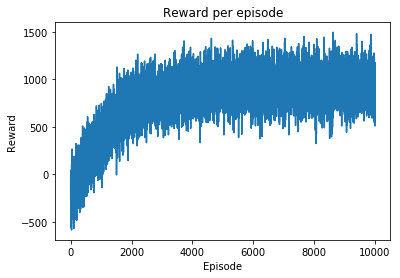

In [140]:
plt.plot(episodes,rewards_per_episode)
plt.title('Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Q value convergence for state action pair

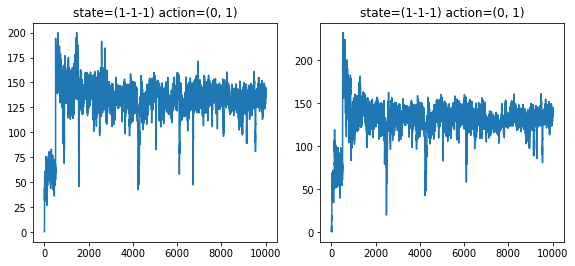

In [142]:
plt.figure(0, figsize=(16, 7))
plt.subplot(241)
plt.title('state=(1-1-1) action=(0, 1)')
plt.plot(np.arange(len(States_track[(1,6,4)][(1, 4)])),
         np.asarray(States_track[(1,6,4)][(1, 4)]))
plt.subplot(242)
plt.title('state=(1-1-1) action=(0, 1)')
plt.plot(np.arange(len(States_track[(1,11,5)][(1, 4)])),
         np.asarray(States_track[(1,11,5)][(1, 4)]))
plt.tight_layout()
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [36]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [15]:
import matplotlib.pyplot as plt

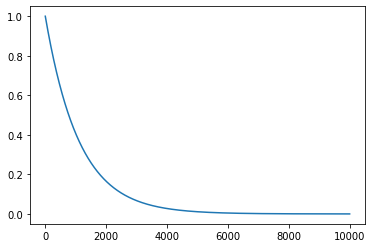

In [16]:
plt.plot(time, epsilon)
plt.show()

In [49]:

epsilon2=[]
for i in range(0,10000):
    if i==0:
        epsilon2.append(1)
    else:
        epsilon2.append(0.997 * epsilon2[i-1])

In [51]:
epsilon2=[]
for i in range(0,10000):
    if i==0:
        epsilon2.append(1)
    else:
        epsilon2.append(epsilon2[i-1] * 0.999)

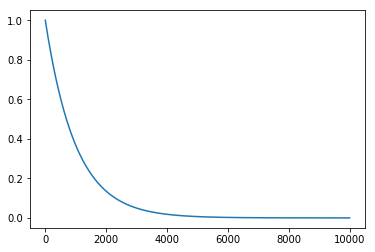

In [52]:
plt.plot(time, epsilon2)
plt.show()